# PREPROCESSING

ATTENTION-LSTM Forecasting with VMD Decomposition on ETTh1 Dataset

In this experiment, we use the ETTh1 dataset (Electricity Transformer Temperature, hourly data) to forecast the oil temperature (OT).
We first apply **Variational Mode Decomposition (VMD)** to extract intrinsic mode components (IMFs) from the `OT` series, 
then use an **Attention-based LSTM (Attn-LSTM)** to capture temporal dependencies and focus on informative time steps.



## Import-Params-Read-Visualization

In [3]:
# Parameters
SEQ_LEN = 48  # past 24 hours for each sample
TARGET_COL = 'OT'  # target variable: Oil Temperature
FEATURE_COLS = ['OT', 'HUFL','HULL','MUFL','MULL','LUFL','LULL']
EPOCHS = 50 
BATCH_SIZE = 16
DROPOUT = 0.2
LEARNING_RATE = 1e-3

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Softmax
from vmdpy import VMD
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Lambda, Input, LSTM, Dense, Dropout,Bidirectional, Layer,LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import random
from tensorflow.keras.layers import Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import Concatenate


2025-12-09 13:16:34.342418: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-09 13:16:34.349313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765273594.357116  152697 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765273594.359511  152697 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765273594.365655  152697 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [7]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
from torch.utils.data import Dataset, DataLoader


Using device: cuda


In [6]:
save_dir = os.path.expanduser("~/Project/Nested_Attention_BiLSTM_VMD/data/raw")
os.makedirs(save_dir, exist_ok=True)
# Full file path
file_path = os.path.join(save_dir, "ETTh1.csv")
# Load it whenever needed
df = pd.read_csv(file_path)
print(df.head())
df.columns = df.columns.str.strip().str.replace('\ufeff', '')
print(df.columns)
# Ensure datetime type
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
data = df[[TARGET_COL]].values


                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000
Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')


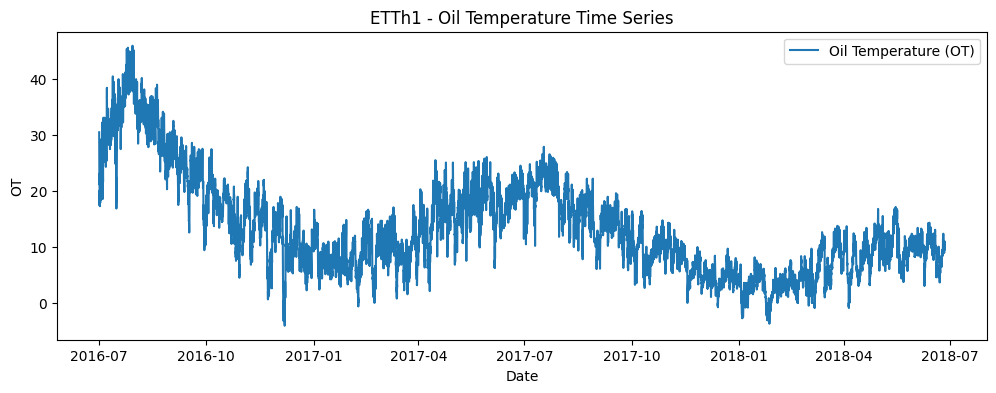

In [7]:
# Visualize
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['OT'], label='Oil Temperature (OT)')
plt.title('ETTh1 - Oil Temperature Time Series')
plt.xlabel('Date')
plt.ylabel('OT')
plt.legend()
plt.show()

## X,Y  and Train_test_split Simple

In [8]:
# =====================================================
# Split Train/Test
# =====================================================
split_idx = int(len(df) * 0.8)
X_train, X_test = df[FEATURE_COLS].values[:split_idx], df[FEATURE_COLS].values[split_idx:]
y_train, y_test = df[TARGET_COL].values[:split_idx].reshape(-1,1), df[TARGET_COL].values[split_idx:].reshape(-1,1)

# =====================================================
# Helper: Create sequences
# =====================================================
def create_sequences(X, y, seq_len):
    """
    Create sequences of length seq_len (X only)
    """
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        seq_x = X[i:i+seq_len]          # shape: (seq_len, num_features)
        seq_y = y[i+seq_len]            # target aligned after the sequence

        Xs.append(seq_x)
        ys.append(seq_y)

    return np.array(Xs), np.array(ys)

# =====================================================
# Train/Test Sequences
# =====================================================
X_train_seq, y_train_seq = create_sequences(X_train, y_train, SEQ_LEN)
X_test_seq,  y_test_seq  = create_sequences(X_test,  y_test,  SEQ_LEN)

# =====================================================
# Scale X sequences
# =====================================================
scaler_x = MinMaxScaler()

num_train_seq, seq_len, feat_dim = X_train_seq.shape
X_train_scaled = scaler_x.fit_transform(X_train_seq.reshape(-1, feat_dim)).reshape(num_train_seq, seq_len, feat_dim)
num_test_seq = X_test_seq.shape[0]
X_test_scaled = scaler_x.transform(X_test_seq.reshape(-1, feat_dim)).reshape(num_test_seq, seq_len, feat_dim)

# =====================================================
# Scale y (target) sequences
# =====================================================
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train_seq.reshape(-1,1))
y_test_scaled  = scaler_y.transform(y_test_seq.reshape(-1,1))

## CUSTOM PYTORCH LAYERS

In [21]:
# -------------------------
# xLSTM Cell
# -------------------------
class xLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim

        self.W_i = nn.Linear(input_dim, hidden_dim)
        self.U_i = nn.Linear(hidden_dim, hidden_dim)

        self.W_f = nn.Linear(input_dim, hidden_dim)
        self.U_f = nn.Linear(hidden_dim, hidden_dim)

        self.W_o = nn.Linear(input_dim, hidden_dim)
        self.U_o = nn.Linear(hidden_dim, hidden_dim)

        self.W_c = nn.Linear(input_dim, hidden_dim)
        self.U_c = nn.Linear(hidden_dim, hidden_dim)
        self.V_c = nn.Linear(input_dim, hidden_dim)

    def forward(self, x, state):
        h_prev, c_prev = state
        i = torch.sigmoid(self.W_i(x) + self.U_i(h_prev))
        f = torch.sigmoid(self.W_f(x) + self.U_f(h_prev))
        o = torch.sigmoid(self.W_o(x) + self.U_o(h_prev))
        g = torch.tanh(self.W_c(x) + self.U_c(h_prev))
        m = torch.sigmoid(self.V_c(x))
        c = f * c_prev + i * (g * m)
        h = o * torch.tanh(c)
        return h, (h, c)

# -------------------------
# Multi-layer xLSTM
# -------------------------
class MultiLayerxLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.1):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList()

        self.layers.append(xLSTMCell(input_size, hidden_size))
        for _ in range(1, num_layers):
            self.layers.append(xLSTMCell(hidden_size, hidden_size))

    def forward(self, x):
        B, T, F = x.size()
        states = [(torch.zeros(B, self.hidden_size, device=x.device),
                   torch.zeros(B, self.hidden_size, device=x.device))
                  for _ in range(self.num_layers)]
        outputs = []

        for t in range(T):
            inp = x[:, t, :]
            for l, layer in enumerate(self.layers):
                h, (h_new, c_new) = layer(inp, states[l])
                states[l] = (h_new, c_new)
                inp = self.dropout(h) if l < self.num_layers - 1 else h
            outputs.append(inp.unsqueeze(1))
        outputs = torch.cat(outputs, dim=1)
        return outputs, states[-1]

# -------------------------
# TFT-style Hybrid Model (no VMD)
# -------------------------
class TFTStyleHybrid(nn.Module):
    def __init__(self, seq_len, in_features,
                 xhidden=64, xlayers=2, num_heads=4, att_dim=64, dropout=0.1,
                 output_size=1):
        super().__init__()
        self.seq_len = seq_len
        self.in_features = in_features
        self.split = in_features // 2  # just half of the input features

        # multi-layer xLSTM for each group
        self.group1 = MultiLayerxLSTM(input_size=self.split, hidden_size=xhidden, num_layers=xlayers, dropout=dropout)
        self.group2 = MultiLayerxLSTM(input_size=in_features - self.split, hidden_size=xhidden, num_layers=xlayers, dropout=dropout)

        self.proj_g1 = nn.Linear(xhidden, att_dim)
        self.proj_g2 = nn.Linear(xhidden, att_dim)

        # multi-head attention
        self.mha = nn.MultiheadAttention(embed_dim=att_dim, num_heads=num_heads, batch_first=True)

        self.head = nn.Sequential(
            nn.Linear(att_dim * 2, xhidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(xhidden, output_size)
        )

    def forward(self, x):
        # x: (B, T, F)
        g1 = x[:, :, :self.split]
        g2 = x[:, :, self.split:]

        o1, _ = self.group1(g1)
        o2, _ = self.group2(g2)

        last1 = o1[:, -1, :]
        last2 = o2[:, -1, :]

        q = self.proj_g1(last1).unsqueeze(1)
        k = self.proj_g2(last2).unsqueeze(1)
        v = k

        att1, _ = self.mha(q, k, v, need_weights=False)
        att2, _ = self.mha(k, q, q, need_weights=False)

        merged = torch.cat([att1.squeeze(1), att2.squeeze(1)], dim=-1)
        out = self.head(merged)
        return out



## CUSTOM TENSORFLOW LAYERS

In [9]:
# ===================================================
# PERFORMER ATTENTION
# ===================================================
class PerformerAttention(Layer):
    def __init__(self, num_heads, model_dim, kernel_eps=1e-6, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.model_dim = model_dim
        self.kernel_eps = kernel_eps
        self.dropout = Dropout(dropout)
        self.head_dim = model_dim // num_heads
        assert model_dim % num_heads == 0, "model_dim must be divisible by num_heads"

    def build(self, input_shape):
        # Linear projections
        self.Wq = Dense(self.model_dim)
        self.Wk = Dense(self.model_dim)
        self.Wv = Dense(self.model_dim)
        self.Wo = Dense(self.model_dim)
        
        # Random Gaussian projection for FAVOR+
        self.proj = self.add_weight(
            shape=(self.head_dim, self.head_dim),
            initializer="random_normal",
            trainable=False,
            name="proj_matrix"
        )

    def kernel(self, x):
        # FAVOR+ kernel Φ(x)
        x_proj = tf.einsum("...nd,df->...nf", x, self.proj)
        return tf.nn.relu(x_proj) + self.kernel_eps

    def split_heads(self, x):
        B = tf.shape(x)[0]
        T = tf.shape(x)[1]
        x = tf.reshape(x, (B, T, self.num_heads, self.head_dim))
        return tf.transpose(x, [0, 2, 1, 3])  # (B, H, T, Dh)

    def merge_heads(self, x):
        B = tf.shape(x)[0]
        T = tf.shape(x)[2]
        x = tf.transpose(x, [0, 2, 1, 3])
        return tf.reshape(x, (B, T, self.model_dim))

    def call(self, x, training=False):
        Q, K, V = x  # all shape (B, T, model_dim)
        
        # Linear projections + split heads
        Q = self.split_heads(self.Wq(Q))
        K = self.split_heads(self.Wk(K))
        V = self.split_heads(self.Wv(V))
        
        # FAVOR+ kernel
        Q_phi = self.kernel(Q)  # (B, H, T, Dh)
        K_phi = self.kernel(K)
        
        # Compute KV and normalization
        KV = tf.einsum("bhnd,bhne->bhde", K_phi, V)  # (B,H,Dh,Dh)
        Z = 1.0 / (tf.einsum("bhnd,bhd->bhn", Q_phi, tf.reduce_sum(K_phi, axis=2)) + 1e-6)
        out = tf.einsum("bhnd,bhde,bhn->bhne", Q_phi, KV, Z)
        
        # Merge heads
        out = self.merge_heads(out)
        return self.Wo(out)

# ===================================================
# VAE SAMPLING LAYER
# ===================================================
class KLDivergenceLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        kl = -0.5 * tf.reduce_mean(
            1 + log_var - tf.square(mu) - tf.exp(log_var)
        )
        self.add_loss(kl)
        return inputs
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        eps = tf.random.normal(tf.shape(mu))
        return mu + tf.exp(0.5 * log_var) * eps

# =====================================================
# 2️⃣ Bahdanau-style Attention Layer
# =====================================================
class AttentionLayer_Bahdanau(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer_Bahdanau, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer="glorot_uniform",
            trainable=True,
            name="att_weight"
        )
        self.b = self.add_weight(
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True,
            name="att_bias"
        )
        self.u = self.add_weight(
            shape=(input_shape[-1],),
            initializer="glorot_uniform",
            trainable=True,
            name="context_vector"
        )
        super(AttentionLayer_Bahdanau, self).build(input_shape)

    def call(self, x):
        # x shape: (batch, time_steps, features)
        u_it = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)   # (batch, time, features)
        a_it = tf.tensordot(u_it, self.u, axes=1)                  # (batch, time)
        a_it = tf.nn.softmax(a_it, axis=1)                         # (batch, time)
        a_it = tf.expand_dims(a_it, axis=-1)                       # (batch, time, 1)
        weighted_output = x * a_it                                  # (batch, time, features)
        return tf.reduce_sum(weighted_output, axis=1)              # (batch, features)

    def compute_output_shape(self, input_shape):
        # output shape: (batch, features)
        return (input_shape[0], input_shape[2])


def build_attlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):
    inp = Input(shape=input_shape)
    
    # Encoder LSTM
    x = LSTM(lstm1_units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)
    
    # Attention
    att_out = AttentionLayer_Bahdanau()(x)
    
    # Decoder LSTM 
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM(lstm2_units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    
    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr), loss='mse', metrics=['mae'])
    return model

# ========================================
# 📌     LSTM + Residual Connection + LayerNorm
# ========================================
class LSTM_residual_norm(Layer):
    def __init__(self, units, dropout=0.1, **kwargs):
        super(LSTM_residual_norm, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout

        self.lstm = LSTM(units, return_sequences=True)
        self.dropout_layer = Dropout(dropout)
        self.norm = LayerNormalization()

    def build(self, input_shape):
        input_dim = input_shape[-1]    # <-- Detect feature count automatically

        # Projection for residual connection
        self.proj = Dense(self.units)  # input_dim → units

        super().build(input_shape)

    def call(self, x):
        h = self.lstm(x)
        h = self.dropout_layer(h)

        h_res = self.proj(x)   # Now works for any feature dimension

        return self.norm(h + h_res)

# ========================================
# 📌  Attention(Bahdanau) + LSTM + Residual Connection + LayerNorm
# ========================================
def build_att_customlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):
    inp = Input(shape=input_shape)
    
    # Encoder LSTM
    x = LSTM_residual_norm(lstm1_units)(inp)
    x = Dropout(dropout)(x)
    
    # Attention
    att_out = AttentionLayer_Bahdanau()(x)
    
    # Decoder LSTM 
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM_residual_norm(lstm2_units)(x)
    x = Dropout(dropout)(x)
    
    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr), loss='mse', metrics=['mae'])
    return model
    
# =========================================================
# 📌  Custom Luong Attention
# score = h_t · W · h_s  (dot-product)
# =========================================================
class LuongAttention(Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.Wq = Dense(units)
        self.Wv = Dense(units)

    def call(self, query, value, mask=None):
        # Project both → SAME dimension
        q = self.Wq(query)      # (B, T, units)
        v = self.Wv(value)      # (B, T, units)

        # Dot product score
        score = tf.matmul(q, v, transpose_b=True)  # (B, T, T)

        if mask is not None:
            score += (mask * -1e9)

        # Use tf.nn.softmax (Keras-safe)
        attn_weights = tf.nn.softmax(score, axis=-1)     # (B, T, T)
        context = tf.matmul(attn_weights, v)             # (B, T, units)

        return context

# =========================================================
# 📌  Temporal Attention (per timestep)
# =========================================================
class TemporalAttention(Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        # input_shape = (batch, timesteps, features)
        d = input_shape[-1]

        self.Wt = Dense(self.units, activation='tanh')
        self.vt = Dense(1)

    def call(self, x):
        # score shape -> (batch, timesteps, units)
        h = self.Wt(x)

        # score shape -> (batch, timesteps, 1)
        score = self.vt(h)

        # attention weights
        alpha = tf.nn.softmax(score, axis=1)

        # weighted sum (batch, timesteps, features) -> (batch, features)
        context = tf.reduce_sum(alpha * x, axis=1)

        return context
        
def build_Tattlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):

    inp = Input(shape=input_shape)

    # Encoder LSTM
    x = LSTM(lstm1_units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)

    # Temporal Attention
    att_out = TemporalAttention(units=lstm1_units)(x)

    # Decoder LSTM - convert context vector to sequence again
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM(lstm2_units, return_sequences=False)(x)
    x = Dropout(dropout)(x)

    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)

    model = Model(inp, out)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model
# =========================================================
# 📌  Cross-Attention (Query from XLSTM, Key/Value from VMD input)
# =========================================================
class CrossAttention(Layer):
    def __init__(self, num_heads=4, key_dim=32):
        super().__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, query, context, mask=None):
        return self.mha(query=query, value=context, key=context, attention_mask=mask)


# =========================================================
# 📌  Causal Masking (prevent future leakage)
# =========================================================
def causal_mask(seq_len):
    mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    return mask[None, None, :, :]



# =========================================================
# 📌  TFT Multi-Head Temporal self-Attention Layer (Keras)
#     this is a valid implementation of the temporal self-attention block inspired by the TFT paper:
#     Multi-head scaled dot-product attention
#     Decoder state as query
#     Encoder outputs as key/value
#     Layer norm + residual
#     Optional causal masking
#     It is simplified (no gating via GRN or VSN), but the attention math is correct and aligned with Transformer/TFT definitions.
# ========================================================= 
class TFTTemporalAttention(Layer):
    def __init__(self, num_heads, model_dim, dropout_rate=0.1,
                 use_mask=False, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.model_dim = model_dim
        self.dropout_rate = dropout_rate
        self.use_mask = use_mask
        
        assert model_dim % num_heads == 0
        self.head_dim = model_dim // num_heads

        self.Wq = Dense(model_dim)
        self.Wk = Dense(model_dim)
        self.Wv = Dense(model_dim)
        self.Wo = Dense(model_dim)

        self.layernorm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(dropout_rate)

    def build(self, input_shape):
        self.Wq.build(input_shape[0])
        self.Wk.build(input_shape[0])
        self.Wv.build(input_shape[0])
        self.Wo.build((None, None, self.model_dim))
        self.layernorm.build((None, None, self.model_dim))
        self.built = True

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1,
                           self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, training=None):
        encoder_out, decoder_state = inputs

        batch_size = tf.shape(encoder_out)[0]

        dec_expanded = tf.repeat(
            tf.expand_dims(decoder_state, axis=1),
            repeats=tf.shape(encoder_out)[1],
            axis=1
        )

        Q = self.Wq(dec_expanded)
        K = self.Wk(encoder_out)
        V = self.Wv(encoder_out)

        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)

        score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.cast(tf.sqrt(float(self.head_dim)), tf.float32)
        score = score / scale

        if self.use_mask:
            T = tf.shape(encoder_out)[1]
            mask = tf.linalg.band_part(tf.ones((T, T)), -1, 0)
            mask = 1e-9 * (1 - mask)
            score += mask

        alpha = tf.nn.softmax(score, axis=-1)
        att_out = tf.matmul(alpha, V)

        att_out = tf.transpose(att_out, perm=[0, 2, 1, 3])
        att_out = tf.reshape(att_out,
                             (batch_size, -1, self.model_dim))

        out = self.Wo(att_out)

        # residual: input must have same dim
        out = self.layernorm(out)

        return out


def build_TFTattlstm_model(input_shape, lstm1_units=100, lstm2_units=100,
                            dense_units=32, num_heads=8, model_dim=64, dropout=0.1):

    # -------------------------
    # 0. Input
    # -------------------------
    encoder_inputs = Input(shape=input_shape)

    # -------------------------
    # 1. Encoder LSTM
    # -------------------------
    enc_out = LSTM(lstm1_units, return_sequences=True)(encoder_inputs)
    enc_out = Dropout(dropout)(enc_out)
    enc_out = LayerNormalization()(enc_out)
    enc_out = Dense(model_dim)(enc_out)  # project to model_dim
    enc_out = LayerNormalization()(enc_out)

    # -------------------------
    # 1b. Bahdanau Attention applied to encoder
    # -------------------------
    bahdanau_att_1 = AttentionLayer_Bahdanau()(enc_out)
    bahdanau_att_enc = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_1)

    # -------------------------
    # 2. Decoder LSTM
    # -------------------------
    dec_out = LSTM(lstm2_units, return_sequences=True)(bahdanau_att_enc)
    dec_out = Dropout(dropout)(dec_out)
    dec_out = Dense(model_dim)(dec_out)  # ensure same feature dimension
    dec_out = LayerNormalization()(dec_out)

    # Bahdanau attention over decoder
    bahdanau_att_dec = AttentionLayer_Bahdanau()(dec_out)  # shape: (batch, model_dim)

    # -------------------------
    # 3. TFT Multi-Head Attention Stack
    # -------------------------
    att_layer = TFTTemporalAttention(num_heads=num_heads, model_dim=model_dim)
    att_out = att_layer([bahdanau_att_enc, bahdanau_att_dec])

    # -------------------------
    # 4. Dense output
    # -------------------------
    x = Bidirectional(LSTM(dense_units))(att_out)
    output = Dense(1)(x)

    # -------------------------
    # 5. Model compile
    # -------------------------
    model = Model(encoder_inputs, output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model

def build_TFTattlstm_model2(input_shape, lstm1_units=100, lstm2_units=100,
                            dense_units=32, num_heads=8, model_dim=64, dropout=0.1):

    # -------------------------
    # 0. Input
    # -------------------------
    input_group = Input(shape=input_shape)

    # -------------------------
    # 1. Encoder LSTM
    # -------------------------
    group1 = LSTM(lstm1_units, return_sequences=True)(input_group)
    group1 = Dropout(dropout)(group1)

    # -------------------------
    # 1b. Bahdanau Attention applied to encoder
    # -------------------------
    bahdanau_att_group1 = AttentionLayer_Bahdanau()(group1)
    bahdanau_att_group1 = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_group1)

    # -------------------------
    # 2. Decoder LSTM
    # -------------------------
    group2 = LSTM(lstm1_units, return_sequences=True)(input_group)
    group2 = Dropout(dropout)(group2)

    # Bahdanau attention over decoder
    bahdanau_att_group2 = AttentionLayer_Bahdanau()(group2)
    bahdanau_att_group2 = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_group2)

    # -------------------------
    # 3. TFT Multi-Head Attention Stack
    # -------------------------
    att_layer = TFTTemporalAttention(num_heads=num_heads, model_dim=model_dim)
    att_out = att_layer([bahdanau_att_group1, bahdanau_att_group2])

    # -------------------------
    # 4. Dense output
    # -------------------------
    x = Bidirectional(LSTM(dense_units))(att_out)
    output = Dense(1)(x)

    # -------------------------
    # 5. Model compile
    # -------------------------
    model = Model(input_group, output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model


def build_TFTattlstm_model3(input_shape=(24,8), 
                            lstm1_units=100,
                            dense_units=32, 
                            num_heads=8, 
                            model_dim=64,
                            dropout=0.1):

    # -------------------------
    # 0. Input
    # -------------------------
    input_group = Input(shape=input_shape)   # (24, 8)

    # -------------------------
    # **Split input: group1 = first 4 features, group2 = next 4**
    # -------------------------
    group1_input = Lambda(lambda x: x[:, :, :6])(input_group)   # (24, 4)
    group2_input = Lambda(lambda x: x[:, :, 6:])(input_group)   # (24, 4)
    # -------------------------
    # 1. Encoder LSTM for Group 1
    # -------------------------
    group1 = LSTM(lstm1_units, return_sequences=True)(group1_input)
    group1 = Dropout(dropout)(group1)

    bahdanau_att_group1 = AttentionLayer_Bahdanau()(group1)
    bahdanau_att_group1 = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_group1)
    # -------------------------
    # 2. Encoder LSTM for Group 2
    # -------------------------
    group2 = LSTM(lstm1_units, return_sequences=True)(group2_input)
    group2 = Dropout(dropout)(group2)

    bahdanau_att_group2 = AttentionLayer_Bahdanau()(group2)
    bahdanau_att_group2 = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_group2)
    # -------------------------
    # 3. TFT Multi-Head Temporal Attention
    # -------------------------
    att_layer = TFTTemporalAttention(num_heads=num_heads, model_dim=model_dim)
    att_out = att_layer([bahdanau_att_group1, bahdanau_att_group2])
    # -------------------------
    # 4. Dense Output
    # -------------------------
    output = Dense(1)(att_out)
    # -------------------------
    # 5. Compile Model
    # -------------------------
    model = Model(inputs=input_group, outputs=output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model



# ============================
# BUILD Performer attlstm MODEL WITH cross attention
# ============================

def build_TFTattlstm_model4(
        input_shape=(24,8), 
        lstm1_units=100,
        dense_units=32, 
        num_heads=8, 
        model_dim=64,
        dropout=0.1):

    # -------------------------
    # 0. Input
    # -------------------------
    input_group = Input(shape=input_shape)   # (24, 8)

    # -------------------------
    # Split input
    # -------------------------
    group1_input = Lambda(lambda x: x[:, :, :6])(input_group)   
    group2_input = Lambda(lambda x: x[:, :, 6:])(input_group)   

    # -------------------------
    # 1. Encoder LSTM for Group 1
    # -------------------------
    group1 = LSTM(lstm1_units, return_sequences=True)(group1_input)
    group1 = Dropout(dropout)(group1)
    bahdanau_att_group1 = AttentionLayer_Bahdanau()(group1)
    bahdanau_att_group1 = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_group1)

    # -------------------------
    # 2. Encoder LSTM for Group 2
    # -------------------------
    group2 = LSTM(lstm1_units, return_sequences=True)(group2_input)
    group2 = Dropout(dropout)(group2)
    bahdanau_att_group2 = AttentionLayer_Bahdanau()(group2)
    bahdanau_att_group2 = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_group2)

    # -------------------------
    # 3. Cross Attention
    # -------------------------
    cross = CrossAttention(num_heads=num_heads, key_dim=model_dim)

    g1_to_g2 = cross(query=bahdanau_att_group1, context=bahdanau_att_group2)
    g2_to_g1 = cross(query=bahdanau_att_group2, context=bahdanau_att_group1)
    cross_out = Concatenate(axis=1)([g1_to_g2, g2_to_g1])  # shape: (batch, 2, model_dim)

    # -------------------------
    # 4. Multi-Head Attention (replaces Performer)
    # -------------------------
    mha = MultiHeadAttention(num_heads=num_heads, key_dim=model_dim)
    att_out = mha(query=cross_out, value=cross_out, key=cross_out)
    att_out = Dropout(dropout)(att_out)
    att_out = LayerNormalization(epsilon=1e-6)(att_out)

    # -------------------------
    # 5. LSTM + Output
    # -------------------------
    x = Bidirectional(LSTM(dense_units))(att_out)
    output = Dense(1)(x)

    # -------------------------
    # 6. Model
    # -------------------------
    model = Model(inputs=input_group, outputs=output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model
# ============================
# BUILD TFTattlstm MODEL WITH VAE
# ============================
def build_TFTattlstm_model5(
        input_shape=(24, 8),
        lstm1_units=100,
        dense_units=32,
        latent_dim=16,
        num_heads=8,
        model_dim=64,
        dropout=0.1):

    # -------------------------
    # 0. Input
    # -------------------------
    input_group = Input(shape=input_shape)

    # -------------------------
    # 1. Split Inputs
    # -------------------------
    group1_input = Lambda(lambda x: x[:, :, :6])(input_group)
    group2_input = Lambda(lambda x: x[:, :, 6:])(input_group)

    # -------------------------
    # 2. LSTM + Bahdanau Group1
    # -------------------------
    group1 = LSTM(lstm1_units, return_sequences=True)(group1_input)
    group1 = Dropout(dropout)(group1)
    bahdanau1 = AttentionLayer_Bahdanau()(group1)
    bahdanau1 = Lambda(lambda x: tf.expand_dims(x, 1))(bahdanau1)

    # -------------------------
    # 3. LSTM + Bahdanau Group2
    # -------------------------
    group2 = LSTM(lstm1_units, return_sequences=True)(group2_input)
    group2 = Dropout(dropout)(group2)
    bahdanau2 = AttentionLayer_Bahdanau()(group2)
    bahdanau2 = Lambda(lambda x: tf.expand_dims(x, 1))(bahdanau2)

    # -------------------------
    # 4. CONCAT Bahdanau outputs
    # -------------------------
    combined = Concatenate(axis=1)([bahdanau1, bahdanau2])   # (batch, 2, features)

    # -------------------------
    # 5. Flatten for VAE Encoder
    # -------------------------
    flat = Flatten()(combined)
    flat_dim = flat.shape[-1]     # static

    # -------------------------
    # 6. VAE Encoder
    # -------------------------
    mu = Dense(latent_dim)(flat)
    log_var = Dense(latent_dim)(flat)

    # Apply KL divergence correctly
    mu, log_var = KLDivergenceLayer()([mu, log_var])

    # Sampling
    z = Sampling()([mu, log_var])

    # -------------------------
    # 7. VAE Decoder
    # -------------------------
    decoder_hidden = Dense(64, activation="relu")(z)
    decoder_out = Dense(flat_dim, activation="linear")(decoder_hidden)

    decoder_out_reshaped = Reshape((2, flat_dim // 2))(decoder_out)

    # -------------------------
    # 8. TFT Multi-Head Temporal Attention
    # -------------------------
    att_layer = TFTTemporalAttention(num_heads=num_heads, model_dim=model_dim)
    att_out = att_layer([decoder_out_reshaped, decoder_out_reshaped])

    # -------------------------
    # 9. LSTM + Dense Output
    # -------------------------
    x = Bidirectional(LSTM(dense_units))(att_out)
    output = Dense(1)(x)

    # -------------------------
    # 10. Final Model
    # -------------------------
    model = Model(inputs=input_group, outputs=output)

    model.compile(optimizer="adam", loss="mse", metrics=["mae"])

    return model

# ============================
# BUILD TFTattlstm MODEL WITH PERFORMER
# ============================
def build_TFTattlstm_model6(input_shape=(24,8), 
                            lstm1_units=64,
                            dense_units=8, 
                            num_heads=8, 
                            model_dim=64,
                            dropout=0.1):

    # 0. Input
    input_group = Input(shape=input_shape)   # (seq_len, features)

    # 1. Split input
    group1_input = Lambda(lambda x: x[:, :, :6])(input_group)
    group2_input = Lambda(lambda x: x[:, :, 6:])(input_group)

    # 2. LSTM for group1
    group1 = LSTM(lstm1_units, return_sequences=True)(group1_input)
    group1 = Dropout(dropout)(group1)

    # 3. LSTM for group2
    group2 = LSTM(lstm1_units, return_sequences=True)(group2_input)
    group2 = Dropout(dropout)(group2)

    # 4. Performer Attention on each group
    performer_att_group1 = PerformerAttention(num_heads=num_heads, model_dim=model_dim)(
        [group1, group1, group1]
    )
    performer_att_group2 = PerformerAttention(num_heads=num_heads, model_dim=model_dim)(
        [group2, group2, group2]
    )

    # Take last time step for each group
    performer_att_group1 = Lambda(lambda x: x[:, -1, :], name="group1_last_step")(performer_att_group1)
    performer_att_group2 = Lambda(lambda x: x[:, -1, :], name="group2_last_step")(performer_att_group2)

    # 5. Concatenate
    cross_out = Concatenate()([performer_att_group1, performer_att_group2])

    # 6. Dense + Output
    x = Dense(dense_units, activation='relu')(cross_out)
    output = Dense(1)(x)

    # 7. Compile
    model = Model(inputs=input_group, outputs=output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model

# ============================
# BUILD TFTattlstm MODEL WITH PERFORMER and BAHDANAU
# ============================
def build_TFTattlstm_model7(input_shape=(24,8), 
                            lstm1_units=64,
                            dense_units=8, 
                            num_heads=8, 
                            model_dim=64,
                            dropout=0.1):

    # 0. Input
    input_group = Input(shape=input_shape)   # (seq_len, features)


    # 2. LSTM for group1
    group1 = Bidirectional(LSTM(dense_units, return_sequences = True))(input_group)
    group1 = Dropout(dropout)(group1)
    group1 = LSTM(lstm1_units, return_sequences=True)(group1)
    group1 = Dropout(dropout)(group1)

    # 3. LSTM for group2
    group2 = Bidirectional(LSTM(dense_units, return_sequences = True))(input_group)
    group2 = Dropout(dropout)(group2)
    group2 = LSTM(lstm1_units, return_sequences=True)(group2)
    group2 = Dropout(dropout)(group2)

    # 4. Bahdanau Attention for group1
    bahdanau_att_group1 = AttentionLayer_Bahdanau()(group1)
    # Expand dims to match Performer output shape
    bahdanau_att_group1 = Lambda(lambda x: tf.expand_dims(x, axis=1), name="group1_bahdanau_expand")(bahdanau_att_group1)
    # Take last step
    bahdanau_att_group1 = Lambda(lambda x: x[:, -1, :], name="group1_last_step")(bahdanau_att_group1)

    # 5. Performer Attention for group2
    performer_att_group2 = PerformerAttention(num_heads=num_heads, model_dim=model_dim)(
        [group2, group2, group2]
    )
    performer_att_group2 = Lambda(lambda x: x[:, -1, :], name="group2_last_step")(performer_att_group2)

    # 6. Concatenate
    cross_out = Concatenate()([bahdanau_att_group1, performer_att_group2])
    cross_out= Bidirectional(LSTM(dense_units))(cross_out)
    cross_out = Dropout(dropout)(cross_out)
    output = Dense(1)(cross_out)

    # 8. Compile
    model = Model(inputs=input_group, outputs=output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model


## ReLSTM CELL

In [24]:

class CustomLSTMCell(tf.keras.layers.Layer):
    def __init__(self, units, activation='tanh', recurrent_activation='sigmoid', use_bias=True, recurrent_dropout=0.0, **kwargs):
        super(CustomLSTMCell, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.recurrent_activation = tf.keras.activations.get(recurrent_activation)
        self.use_bias = use_bias
        self.recurrent_dropout = recurrent_dropout

    def build(self, input_shape):
        self.input_dim = input_shape[-1] # features number
        
        self.W_f = self.add_weight(shape=(self.input_dim + self.units, self.units), initializer='random_normal', name='W_f')
        self.b_f = self.add_weight(shape=(self.units,), initializer='zeros', name='b_f') if self.use_bias else None
        
        self.W_i = self.add_weight(shape=(self.input_dim + self.units, self.units), initializer='random_normal', name='W_i')
        self.b_i = self.add_weight(shape=(self.units,), initializer='zeros', name='b_i') if self.use_bias else None
        
        self.W_c = self.add_weight(shape=(self.input_dim + self.units, self.units), initializer='random_normal', name='W_c')
        self.b_c = self.add_weight(shape=(self.units,), initializer='zeros', name='b_c') if self.use_bias else None
        
        self.W_o = self.add_weight(shape=(self.input_dim + self.units, self.units), initializer='random_normal', name='W_o')
        self.b_o = self.add_weight(shape=(self.units,), initializer='zeros', name='b_o') if self.use_bias else None

        self.W_s = self.add_weight(shape=(self.input_dim + self.units, self.units), initializer='random_normal', name='W_s')
        self.b_s = self.add_weight(shape=(self.units,), initializer='zeros', name='b_s') if self.use_bias else None

        self.W_ff = self.add_weight(shape=(self.units, self.units), initializer='random_normal', name='W_ff')
        self.b_ff = self.add_weight(shape=(self.units,), initializer='zeros', name='b_ff') if self.use_bias else None
        
        self.W_fe = self.add_weight(shape=(self.units, self.units), initializer='random_normal', name='W_fe')
        self.b_fe = self.add_weight(shape=(self.units,), initializer='zeros', name='b_fe') if self.use_bias else None
        
        self.W_z = self.add_weight(shape=(self.units, self.units), initializer='random_normal', name='W_z')
        self.b_z = self.add_weight(shape=(self.units,), initializer='zeros', name='b_z') if self.use_bias else None
        
        self.W_B = self.add_weight(shape=(self.input_dim + self.units, self.units), initializer='random_normal', name='W_B')
        self.b_B = self.add_weight(shape=(self.units,), initializer='zeros', name='b_B') if self.use_bias else None
        
        

    def call(self, inputs, states, training=None):
        h_t, c_t, fe_t = states
        if 0 < self.recurrent_dropout < 1 and training:
            h_t = tf.nn.dropout(h_t, rate=self.recurrent_dropout)

        concat_h_t = tf.concat([inputs, h_t], axis=-1)
        concat_fe_t = tf.concat([inputs, fe_t], axis=-1)
        concat_c_t = tf.concat([inputs, c_t], axis=-1)
        fe_hat = tf.matmul(concat_fe_t,self.W_s) + (self.b_s if self.use_bias else 0)
        fe_h= fe_hat + tf.matmul(concat_h_t,(1-self.W_s))+ (self.b_s if self.use_bias else 0)
        

        B_hat= tf.matmul(concat_c_t, self.W_B) + (self.b_B if self.use_bias else 0)
        f_t = self.recurrent_activation(tf.matmul(concat_h_t, self.W_f) + (self.b_f if self.use_bias else 0))
        i_t = self.recurrent_activation(tf.matmul(concat_h_t, self.W_i) + (self.b_i if self.use_bias else 0))
        c_hat_t = self.activation(tf.matmul(concat_h_t, self.W_c) + (self.b_c if self.use_bias else 0))
        o_t = self.recurrent_activation(tf.matmul(concat_h_t, self.W_o) + (self.b_o if self.use_bias else 0))
  
        fe_1 = self.recurrent_activation(tf.matmul(B_hat,self.W_z) + (self.b_z if self.use_bias else 0))
        fe_2 = self.activation(tf.matmul(B_hat,self.W_fe) + (self.b_fe if self.use_bias else 0))


        fe_f = tf.matmul(f_t, self.W_ff) + (self.b_ff if self.use_bias else 0)

        c_t_next = f_t * c_t + i_t * c_hat_t
        h_t_next = o_t * self.activation(c_t_next)
        fe_1_2=fe_1 * fe_2
        fe_ff = fe_t * fe_f
        fe_t_next=fe_1_2+fe_ff
        
        return h_t_next, [h_t_next, c_t_next, fe_t_next]
    

    def get_config(self):
        config = super(CustomLSTMCell, self).get_config()
        config.update({
            'units': self.units,
            'activation': tf.keras.activations.serialize(self.activation),
            'recurrent_activation': tf.keras.activations.serialize(self.recurrent_activation),
            'use_bias': self.use_bias,
            'recurrent_dropout': self.recurrent_dropout,
        })
        return config


class CustomLSTM(tf.keras.layers.Layer):
    def __init__(self, units, activation='tanh', recurrent_activation='sigmoid', use_bias=True, return_sequences=False, return_state=False, recurrent_dropout=0.0, unroll=False, **kwargs):
        super(CustomLSTM, self).__init__(**kwargs)
        self.units = units
        self.return_sequences = return_sequences
        self.return_state = return_state
        self.unroll = unroll
        self.cell = CustomLSTMCell(units, activation=activation, recurrent_activation=recurrent_activation, use_bias=use_bias, recurrent_dropout=recurrent_dropout)
        
    def call(self, inputs, training=None):
        batch_size = tf.shape(inputs)[0]
        seq_length = tf.shape(inputs)[1]
        
        h_t = tf.zeros((batch_size, self.units))
        c_t = tf.zeros((batch_size, self.units))
        fe_t = tf.zeros((batch_size, self.units))
        
        states = [h_t, c_t, fe_t]
        
        inputs_transposed = tf.transpose(inputs, [1, 0, 2])
        
        def step(prev_states, x_t):
            
            h_t, c_t, fe_t = prev_states
            
            h_t, [h_t, c_t, fe_t] = self.cell(x_t, [h_t, c_t, fe_t], training=training)
            
            return [h_t, c_t, fe_t]

        if self.unroll:
            # Unroll the loop manually if unroll=True
            outputs = []
            for i in range(seq_length):
                states = step(states, inputs_transposed[i])
                outputs.append(states[0])
            outputs = tf.stack(outputs, axis=0)
            
        else:
            states = tf.scan(step, inputs_transposed, initializer=states, parallel_iterations=1)
            outputs = states[0]
            
        
        outputs = tf.transpose(outputs, [1, 0, 2])
        
        final_states = [states[0][-1], states[1][-1]]
        
        if self.return_sequences:
            if self.return_state:
                return outputs, final_states
            return outputs
        
        if self.return_state:
            return outputs[:, -1, :], final_states
        return outputs[:, -1, :]
    
    def get_config(self):
        config = super(CustomLSTM, self).get_config()
        config.update({
            'units': self.units,
            'activation': tf.keras.activations.serialize(self.cell.activation),
            'recurrent_activation': tf.keras.activations.serialize(self.cell.recurrent_activation),
            'use_bias': self.cell.use_bias,
            'return_sequences': self.return_sequences,
            'return_state': self.return_state,
            'recurrent_dropout': self.cell.recurrent_dropout,
            'unroll': self.unroll,
        })
        return config


# ReLSTM

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 48, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_lstm_4 (CustomLSTM)      │ (None, 48, 90)         │        77,490 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 48, 90)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_lstm_5 (CustomLSTM)      │ (None, 90)             │       122,310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,891 (780.82 KB)

 Trainable params: 199,891 (780.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0037 - mae: 0.0394 - val_loss: 3.4982e-04 - val_mae: 0.0132
Epoch 2/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.0013 - mae: 0.0272 - val_loss: 4.5597e-04 - val_mae: 0.0177
Epoch 3/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 0.0011 - mae: 0.0246 - val_loss: 2.8049e-04 - val_mae: 0.0121
Epoch 4/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 9.3056e-04 - mae: 0.0227 - val_loss: 5.9940e-04 - val_mae: 0.0210
Epoch 5/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 7.8872e-04 - mae: 0.0206 - val_loss: 2.1401e-04 - val_mae: 0.0105
Epoch 6/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 7.4664e-04 - mae: 0.0201 - val_loss: 4.4350e-04 - val_mae: 0.0175
Epoch 7/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 6.9747e-04 - mae: 0.0194 - val_loss: 4.2731e-04 - val_mae: 0.0173
Epoch 8/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 6.3514e-04 - mae: 0.0184 - val_loss: 1.6772e-04 - val_

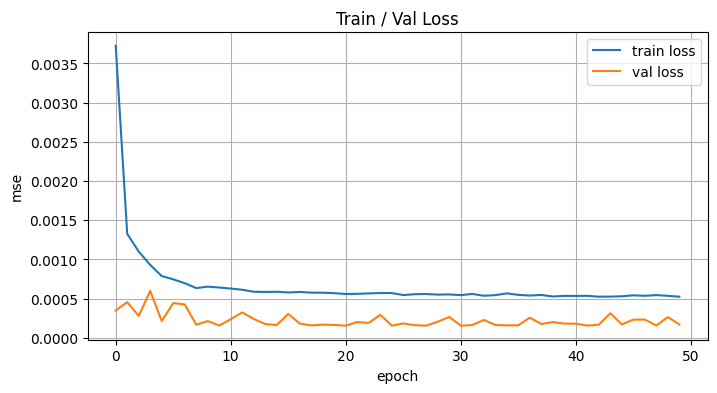

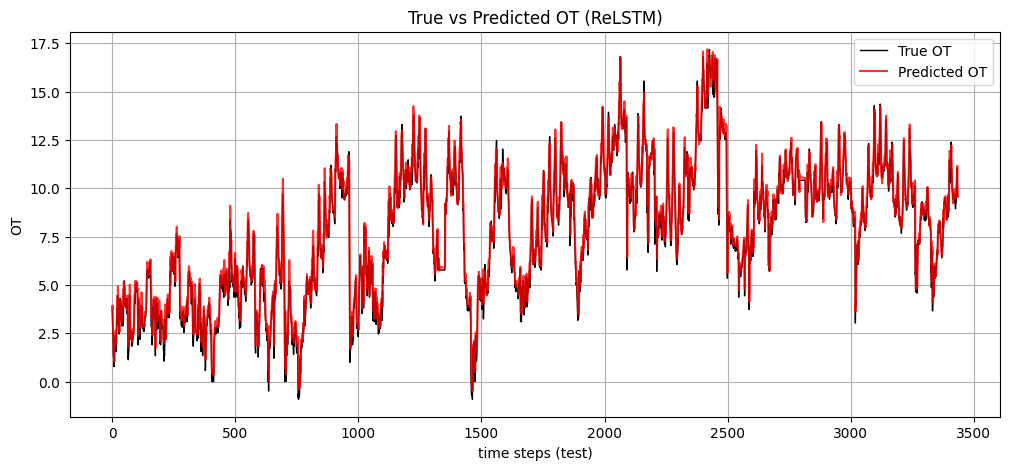

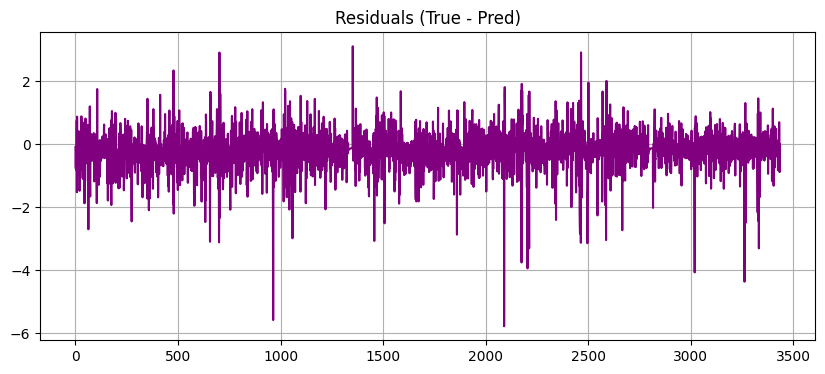

Total Area = 1554.5707073099911
Area + = 420.9897202141583
Area - = -1133.5809870958328
RMS = 0.6552379553104418


In [29]:
# ---------------------------
# ReLSTM model
# ---------------------------
inp = Input(shape=(SEQ_LEN, len(FEATURE_COLS)))
x = CustomLSTM(90, return_sequences=True)(inp)
x = Dropout(DROPOUT)(x)
x = CustomLSTM(90, return_sequences=False)(x)
x = Dropout(DROPOUT)(x)
out = Dense(1)(x)
model_relstm = Model(inp, out)
model_relstm.compile(optimizer=Adam(LEARNING_RATE), loss='mse', metrics=['mae'])

model_relstm.summary()

# ---------------------------
# 6. Train
# ---------------------------
history_relstm = model_relstm.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# ---------------------------
# 7. Predict & inverse-transform
# ---------------------------
y_pred_relstm_scaled = model_relstm.predict(X_test_scaled)
y_pred_relstm_true = scaler_y.inverse_transform(y_pred_relstm_scaled).flatten()

# ---------------------------
# 9. Plots
# ---------------------------
plt.figure(figsize=(8,4))
plt.plot(history_relstm.history['loss'], label='train loss')
plt.plot(history_relstm.history['val_loss'], label='val loss')
plt.xlabel('epoch'); plt.ylabel('mse'); plt.legend(); plt.grid(True)
plt.title('Train / Val Loss')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_seq, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_relstm_true, label='Predicted OT', color='red', alpha=0.8)
plt.xlabel('time steps (test)')
plt.ylabel('OT')
plt.title('True vs Predicted OT (ReLSTM)')
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
res = y_test_seq.squeeze() - y_pred_relstm_true 
plt.plot(res, color='purple')
plt.title('Residuals (True - Pred)')
plt.grid(True)
plt.show()

res = y_test_seq.squeeze() - y_pred_relstm_true
area_total_lstm = np.trapezoid(np.abs(res))
print("Total Area =", area_total_lstm)
area_positive_lstm = np.trapezoid(np.clip(res, 0, None))
area_negative_lstm = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_lstm)
print("Area - =", area_negative_lstm)
vol_rms = np.sqrt(np.mean(res**2))
print("RMS =", vol_rms)

# XLSTM_PYTORCH

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# -------------------------
# Hyperparameters
# -------------------------
LR = 1e-4              # smaller LR for stability

# -------------------------
# Convert to tensors
# -------------------------
X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(y_train_scaled).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float()
y_test_tensor = torch.from_numpy(y_test_scaled).float()

# -------------------------
# Dataset & DataLoader
# -------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
test_dataset  = TimeSeriesDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------
# Model, optimizer, loss
# -------------------------
in_features = X_train_tensor.shape[2]  # number of features
model = TFTStyleHybrid(
    seq_len=SEQ_LEN,
    in_features=in_features,
    xhidden=128,    # try larger hidden for capacity
    xlayers=2,
    num_heads=4,
    att_dim=64,
    dropout=0.1,
    output_size=1
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

# -------------------------
# Training loop with logging
# -------------------------
for epoch in range(EPOCHS):
    model.train()
    train_losses = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred.squeeze(), yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # -------------------------
    # Evaluate on train and test
    # -------------------------
    model.eval()
    def evaluate(loader):
        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                y_true.append(yb.cpu().numpy())
                y_pred.append(pred.squeeze().cpu().numpy())
        return np.concatenate(y_true), np.concatenate(y_pred)

    y_true_train, y_pred_train = evaluate(train_loader)
    y_true_test, y_pred_test = evaluate(test_loader)

    # inverse scale
    y_pred_train_true = scaler_y.inverse_transform(y_pred_train.reshape(-1,1))
    y_true_train_true = scaler_y.inverse_transform(y_true_train.reshape(-1,1))
    y_pred_test_true = scaler_y.inverse_transform(y_pred_test.reshape(-1,1))
    y_true_test_true = scaler_y.inverse_transform(y_true_test.reshape(-1,1))

    # metrics
    train_mse = mean_squared_error(y_true_train_true, y_pred_train_true)
    train_mae = mean_absolute_error(y_true_train_true, y_pred_train_true)
    test_mse = mean_squared_error(y_true_test_true, y_pred_test_true)
    test_mae = mean_absolute_error(y_true_test_true, y_pred_test_true)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {np.mean(train_losses):.4f} | "
          f"Train MSE: {train_mse:.4f}, MAE: {train_mae:.4f} | "
          f"Test MSE: {test_mse:.4f}, MAE: {test_mae:.4f}")

# -------------------------
# Plot predictions
# -------------------------
plt.figure(figsize=(12,5))
plt.plot(y_true_test_true, label='True', color='black', linewidth=1)
plt.plot(y_pred_test_true, label='Predicted', color='red', alpha=0.8)
plt.title('True vs Predicted')
plt.xlabel('Time Steps'); plt.ylabel('Target Value')
plt.legend(); plt.grid(True); plt.show()

# Residuals
residuals = y_true_test_true - y_pred_test_true
plt.figure(figsize=(10,4))
plt.plot(residuals, color='purple')
plt.title('Residuals')
plt.grid(True); plt.show()

# Area & RMS
res = residuals.squeeze()
area_total = np.trapz(np.abs(res))
area_positive = np.trapz(np.clip(res, 0, None))
area_negative = np.trapz(np.clip(res, None, 0))
vol_rms = np.sqrt(np.mean(res**2))

print("Total Area =", area_total)
print("Area + =", area_positive)
print("Area - =", area_negative)
print("RMS =", vol_rms)


/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50 | Train Loss: 0.0393 | Train MSE: 71.9378, MAE: 6.7479 | Test MSE: 59.5915, MAE: 7.0109


/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/50 | Train Loss: 0.0322 | Train MSE: 72.2283, MAE: 6.6652 | Test MSE: 45.4671, MAE: 5.9621


/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3/50 | Train Loss: 0.0321 | Train MSE: 71.4706, MAE: 6.6704 | Test MSE: 49.9524, MAE: 6.3147


/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4/50 | Train Loss: 0.0320 | Train MSE: 70.1275, MAE: 6.7142 | Test MSE: 64.1830, MAE: 7.3405


/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 5/50 | Train Loss: 0.0320 | Train MSE: 71.0518, MAE: 6.6616 | Test MSE: 50.7926, MAE: 6.3793


/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 6/50 | Train Loss: 0.0319 | Train MSE: 70.4325, MAE: 6.6939 | Test MSE: 59.7205, MAE: 7.0324


/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 7/50 | Train Loss: 0.0319 | Train MSE: 71.1899, MAE: 6.7712 | Test MSE: 66.1283, MAE: 7.4618


/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 8/50 | Train Loss: 0.0319 | Train MSE: 70.4880, MAE: 6.7153 | Test MSE: 61.9875, MAE: 7.1872


/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 9/50 | Train Loss: 0.0319 | Train MSE: 72.2523, MAE: 6.6534 | Test MSE: 42.6547, MAE: 5.7310


/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10/50 | Train Loss: 0.0319 | Train MSE: 71.6860, MAE: 6.7409 | Test MSE: 58.5127, MAE: 6.9363


/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 11/50 | Train Loss: 0.0319 | Train MSE: 70.7154, MAE: 6.6530 | Test MSE: 51.6763, MAE: 6.4498


/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 12/50 | Train Loss: 0.0319 | Train MSE: 71.3358, MAE: 6.7149 | Test MSE: 56.8411, MAE: 6.8191


/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 13/50 | Train Loss: 0.0318 | Train MSE: 69.6141, MAE: 6.6331 | Test MSE: 55.0258, MAE: 6.6994


/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 14/50 | Train Loss: 0.0319 | Train MSE: 72.0081, MAE: 6.6482 | Test MSE: 42.8677, MAE: 5.7460


/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 15/50 | Train Loss: 0.0318 | Train MSE: 70.0906, MAE: 6.6856 | Test MSE: 59.8852, MAE: 7.0451


/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 16/50 | Train Loss: 0.0319 | Train MSE: 70.8152, MAE: 6.6817 | Test MSE: 55.0001, MAE: 6.6923


/opt/anaconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


# AttLSTM

📚 Reference for Attention Mechanism

**Bahdanau, Dzmitry; Cho, Kyunghyun; Bengio, Yoshua (2014).**
*Neural Machine Translation by Jointly Learning to Align and Translate.*
arXiv:1409.0473

🔗 [https://arxiv.org/abs/1409.0473](https://arxiv.org/abs/1409.0473)


📚 Reference for VMD (Variational Mode Decomposition)

**Dragomiretskiy, K., & Zosso, D. (2014).**
*Variational Mode Decomposition.*
IEEE Transactions on Signal Processing, 62(3), 531–544.

🔗 [https://doi.org/10.1109/TSP.2013.2288675](https://doi.org/10.1109/TSP.2013.2288675)
🔗 [https://arxiv.org/abs/1406.5858](https://arxiv.org/abs/1406.5858)



I0000 00:00:1765273620.317806  152697 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21059 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 48, 132)        │        73,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer__bahdanau       │ (None, 132)            │        17,688 │
│ (AttentionLayer_Bahdanau)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 132)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 132)            │       139,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,105 (937.91 KB)

 Trainable params: 240,105 (937.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1765273621.952010  152984 cuda_dnn.cc:529] Loaded cuDNN version 90300


868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0049 - mae: 0.0498 - val_loss: 7.9864e-04 - val_mae: 0.0223
Epoch 2/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0018 - mae: 0.0320 - val_loss: 4.0031e-04 - val_mae: 0.0144
Epoch 3/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0013 - mae: 0.0272 - val_loss: 2.8016e-04 - val_mae: 0.0121
Epoch 4/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 8.6329e-04 - mae: 0.0219 - val_loss: 2.9232e-04 - val_mae: 0.0124
Epoch 5/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 7.7338e-04 - mae: 0.0207 - val_loss: 2.8024e-04 - val_mae: 0.0129
Epoch 6/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 7.5547e-04 - mae: 0.0205 - val_loss: 1.9405e-04 - val_mae: 0.0101
Epoch 7/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 9.0851e-04 - mae: 0.0225 - val_loss: 4.0043e-04 - val_mae: 0.0152
Epoch 8/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0061 - mae: 0.0568 - val_loss: 0.0030 - val_mae: 0.0439
Epoch 9/50
868/868 ━━━━

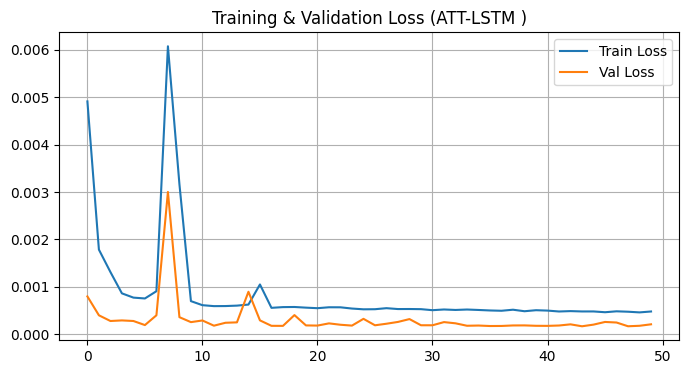

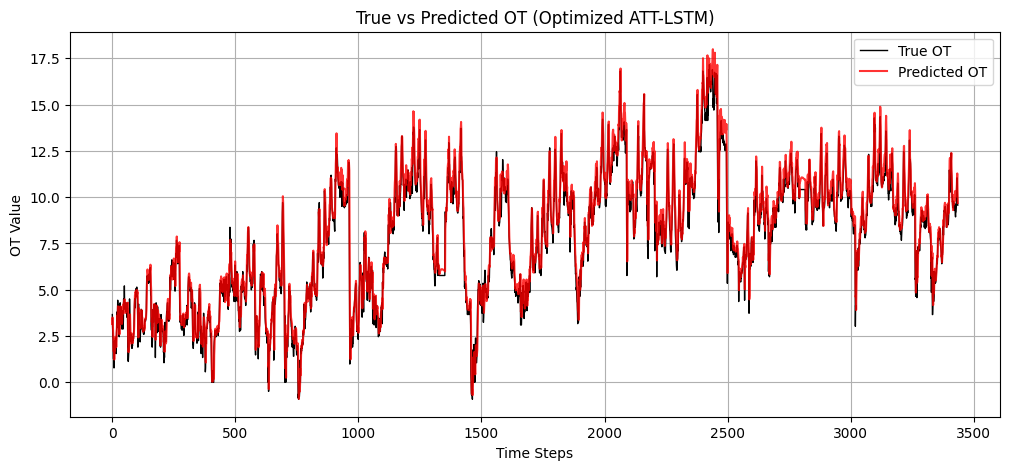

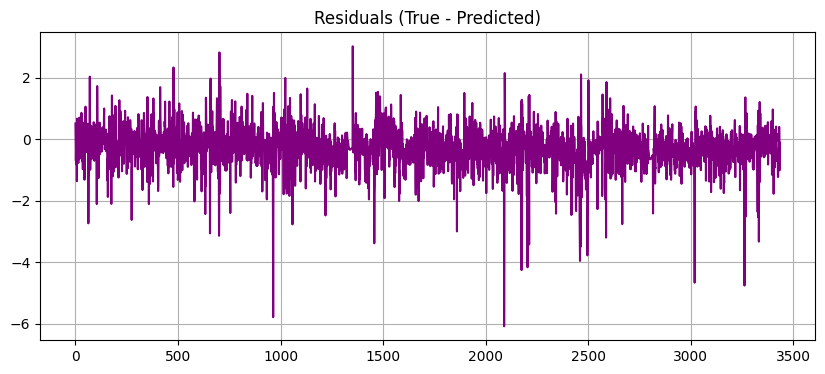

Total Area = 1779.9347186817904
Area + = 378.6629433557391
Area - = -1401.2717753260513
RMS = 0.7262070231679125


In [10]:
model_build_attlstm_model = build_attlstm_model(
    input_shape=(SEQ_LEN, X_train_scaled.shape[2]),
    lstm1_units=132,
    lstm2_units=132,
    dense_units=64
)
model_build_attlstm_model.summary()

history_attlstm = model_build_attlstm_model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_attlstm_scaled = model_build_attlstm_model.predict(X_test_scaled)
y_pred_attlstm_true = scaler_y.inverse_transform(y_pred_attlstm_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_attlstm.history['loss'], label='Train Loss')
plt.plot(history_attlstm.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-LSTM )')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_seq, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_attlstm_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-LSTM)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_seq - y_pred_attlstm_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

res = y_test_seq.squeeze() - y_pred_attlstm_true.squeeze()
area_total_attlstm = np.trapezoid(np.abs(res))
print("Total Area =", area_total_attlstm)
area_positive_attlstm = np.trapezoid(np.clip(res, 0, None))
area_negative_attlstm = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_attlstm)
print("Area - =", area_negative_attlstm)
vol_rms = np.sqrt(np.mean(res**2))
print("RMS =", vol_rms)

# TAttLSTM
Temporary Attention + lstm + vmd
📚 Reference for Attention Mechanism

**Bahdanau, Dzmitry; Cho, Kyunghyun; Bengio, Yoshua (2014).**
*Neural Machine Translation by Jointly Learning to Align and Translate.*
arXiv:1409.0473

🔗 [https://arxiv.org/abs/1409.0473](https://arxiv.org/abs/1409.0473)


📚 Reference for VMD (Variational Mode Decomposition)

**Dragomiretskiy, K., & Zosso, D. (2014).**
*Variational Mode Decomposition.*
IEEE Transactions on Signal Processing, 62(3), 531–544.

🔗 [https://doi.org/10.1109/TSP.2013.2288675](https://doi.org/10.1109/TSP.2013.2288675)
🔗 [https://arxiv.org/abs/1406.5858](https://arxiv.org/abs/1406.5858)



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 48, 132)        │        73,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_attention              │ (None, 132)            │        17,689 │
│ (TemporalAttention)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 132)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 132)            │       139,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,106 (937.91 KB)

 Trainable params: 240,106 (937.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0046 - mae: 0.0476 - val_loss: 9.5821e-04 - val_mae: 0.0251
Epoch 2/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0017 - mae: 0.0308 - val_loss: 5.8247e-04 - val_mae: 0.0176
Epoch 3/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0011 - mae: 0.0245 - val_loss: 3.5399e-04 - val_mae: 0.0149
Epoch 4/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 8.8108e-04 - mae: 0.0222 - val_loss: 5.3816e-04 - val_mae: 0.0201
Epoch 5/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 7.7634e-04 - mae: 0.0207 - val_loss: 3.5928e-04 - val_mae: 0.0144
Epoch 6/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 6.6428e-04 - mae: 0.0192 - val_loss: 3.8716e-04 - val_mae: 0.0156
Epoch 7/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 6.5831e-04 - mae: 0.0189 - val_loss: 3.6218e-04 - val_mae: 0.0145
Epoch 8/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 6.2866e-04 - mae: 0.0185 - val_loss: 7.0473e-04 - val_mae: 0.0237
Epoc

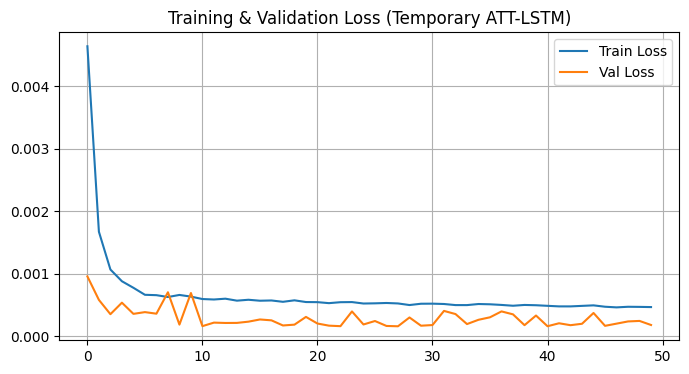

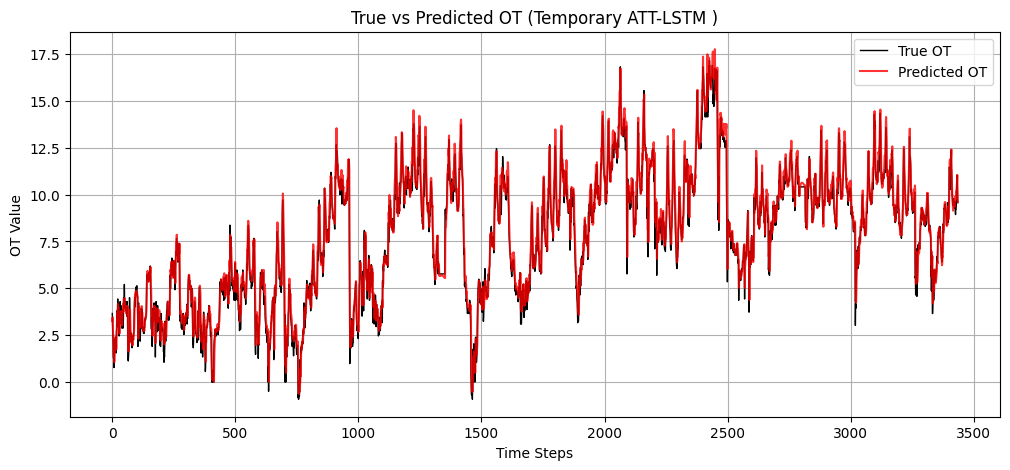

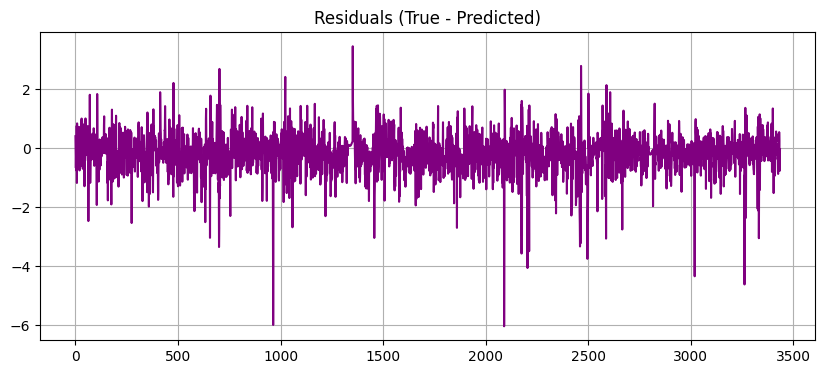

Total Area = 1609.4660487637739
Area + = 487.8463266023318
Area - = -1121.619722161442
RMS = 0.6745079388489966


In [11]:
model_build_Tattlstm_model = build_Tattlstm_model(
    input_shape=(SEQ_LEN, X_train_scaled.shape[2]),
    lstm1_units=132,
    lstm2_units=132,
    dense_units=64
)
model_build_Tattlstm_model.summary()

history_Tattlstm = model_build_Tattlstm_model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_Tattlstm_scaled = model_build_Tattlstm_model.predict(X_test_scaled)
y_pred_Tattlstm_true = scaler_y.inverse_transform(y_pred_Tattlstm_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_Tattlstm.history['loss'], label='Train Loss')
plt.plot(history_Tattlstm.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (Temporary ATT-LSTM)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_seq, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_Tattlstm_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Temporary ATT-LSTM )')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_seq - y_pred_Tattlstm_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

res = y_test_seq.squeeze() - y_pred_Tattlstm_true.squeeze()
area_total_Tattlstm = np.trapezoid(np.abs(res))
print("Total Area =", area_total_Tattlstm)
area_positive_Tattlstm = np.trapezoid(np.clip(res, 0, None))
area_negative_Tattlstm = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_Tattlstm)
print("Area - =", area_negative_Tattlstm)
vol_rms = np.sqrt(np.mean(res**2))
print("RMS =", vol_rms)

# TFT Multi-Head Temporal self-Attention lstm

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 48, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 48, 128)   │     69,632 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 48, 128)   │          0 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 48, 128)   │        256 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 48, 64)    │      8,256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 48, 64)    │        128 │ dense_6[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ layer_normalizat… │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 1, 128)    │     98,816 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1, 128)    │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1, 64)     │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 64)     │        128 │ dense_7[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ layer_normalizat… │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tft_temporal_atten… │ (None, None, 64)  │     16,768 │ lambda[0][0],     │
│ (TFTTemporalAttent… │                   │            │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 32)        │     10,368 │ tft_temporal_att… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │         33 │ bidirectional[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 221,089 (863.63 KB)

 Trainable params: 221,089 (863.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0047 - mae: 0.0488 - val_loss: 6.4329e-04 - val_mae: 0.0196
Epoch 2/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0016 - mae: 0.0303 - val_loss: 9.4644e-04 - val_mae: 0.0248
Epoch 3/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0011 - mae: 0.0253 - val_loss: 5.6136e-04 - val_mae: 0.0192
Epoch 4/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 8.6852e-04 - mae: 0.0223 - val_loss: 2.4378e-04 - val_mae: 0.0115
Epoch 5/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 8.3546e-04 - mae: 0.0218 - val_loss: 2.5799e-04 - val_mae: 0.0117
Epoch 6/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 7.0873e-04 - mae: 0.0200 - val_loss: 1.8944e-04 - val_mae: 0.0097
Epoch 7/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 7.2086e-04 - mae: 0.0202 - val_loss: 3.1306e-04 - val_mae: 0.0134
Epoch 8/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 6.1983e-04 - mae: 0.0186 - val_loss: 6.3239e-04 - val_mae: 0.0222


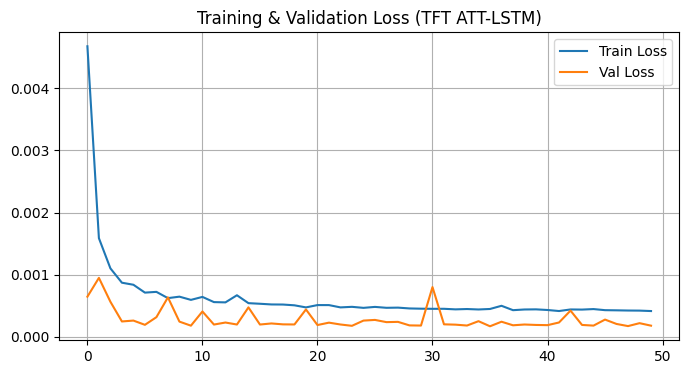

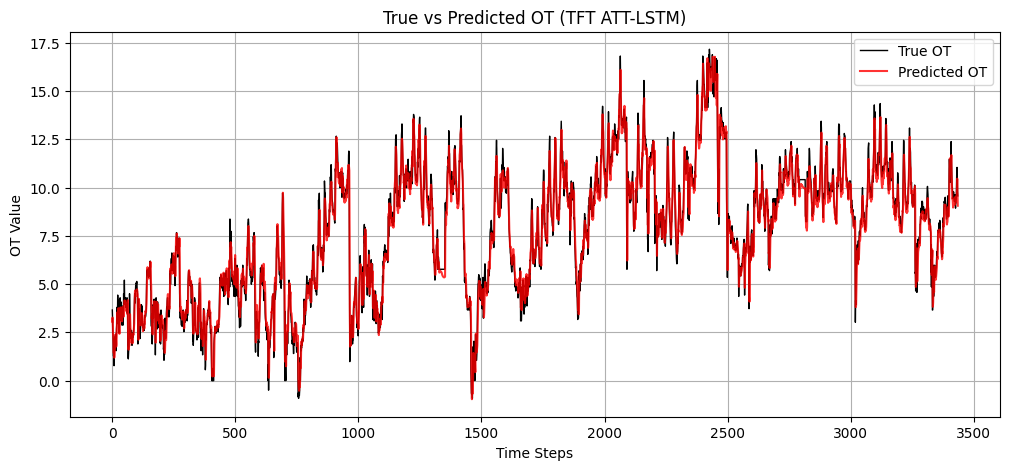

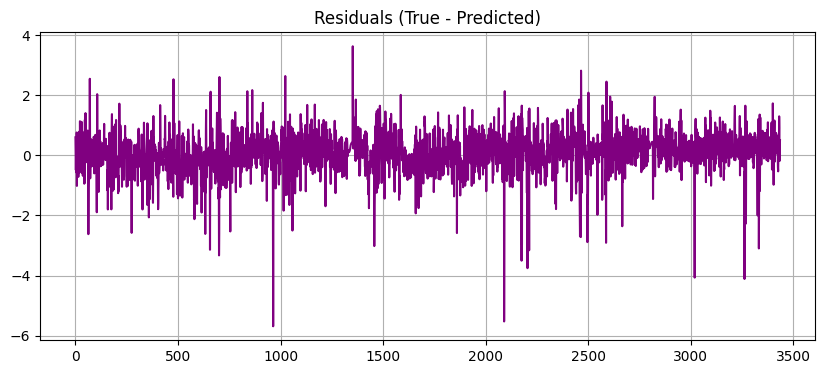

Total Area = 1626.8247311711311
Area + = 934.4351700767875
Area - = -692.3895610943437
RMS = 0.6644862535458755


In [12]:
model_build_TFTattlstm_model = build_TFTattlstm_model(
    input_shape=(SEQ_LEN, X_train_scaled.shape[2]),
    lstm1_units=128,
    lstm2_units=128,
    dense_units=16,
    num_heads=8,
    model_dim=64,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm = model_build_TFTattlstm_model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_scaled = model_build_TFTattlstm_model.predict(X_test_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_true = y_pred_TFTattlstm_true.reshape(y_pred_TFTattlstm_scaled.shape[0],
                                                                y_pred_TFTattlstm_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_seq, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_seq - y_pred_TFTattlstm_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


res = y_test_seq.squeeze() - y_pred_TFTattlstm_true.squeeze()
area_total_TFTattlstm = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm)
area_positive_TFTattlstm = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm)
print("Area - =", area_negative_TFTattlstm)
vol_rms = np.sqrt(np.mean(res**2))
print("RMS =", vol_rms)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 48, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 48, 128)   │     69,632 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 48, 128)   │     69,632 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 48, 128)   │          0 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 48, 128)   │          0 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 128)       │     16,640 │ dropout_7[0][0]   │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 128)       │     16,640 │ dropout_8[0][0]   │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1, 128)    │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1, 128)    │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tft_temporal_atten… │ (None, None, 64)  │     29,056 │ lambda_1[0][0],   │
│ (TFTTemporalAttent… │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 32)        │     10,368 │ tft_temporal_att… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         33 │ bidirectional_1[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 212,001 (828.13 KB)

 Trainable params: 212,001 (828.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0043 - mae: 0.0473 - val_loss: 8.8004e-04 - val_mae: 0.0216
Epoch 2/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0013 - mae: 0.0279 - val_loss: 4.0456e-04 - val_mae: 0.0152
Epoch 3/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0011 - mae: 0.0249 - val_loss: 3.5679e-04 - val_mae: 0.0138
Epoch 4/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 8.8616e-04 - mae: 0.0225 - val_loss: 4.3614e-04 - val_mae: 0.0150
Epoch 5/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 7.5077e-04 - mae: 0.0204 - val_loss: 0.0014 - val_mae: 0.0340
Epoch 6/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0016 - mae: 0.0266 - val_loss: 0.0032 - val_mae: 0.0453
Epoch 7/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0066 - mae: 0.0623 - val_loss: 0.0033 - val_mae: 0.0460
Epoch 8/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0063 - mae: 0.0605 - val_loss: 0.0037 - val_mae: 0.0469
Epoch 9/50
868/868 ━━━━━━━━━━

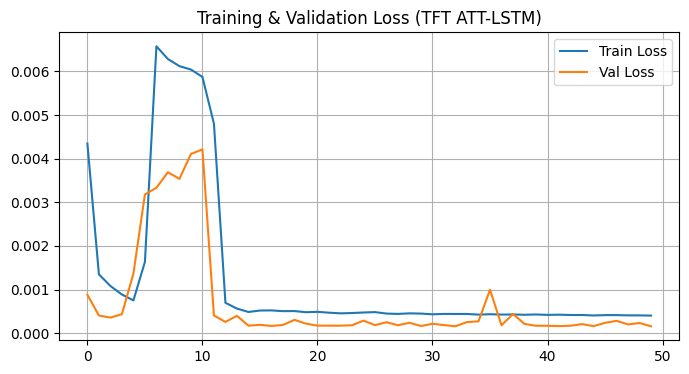

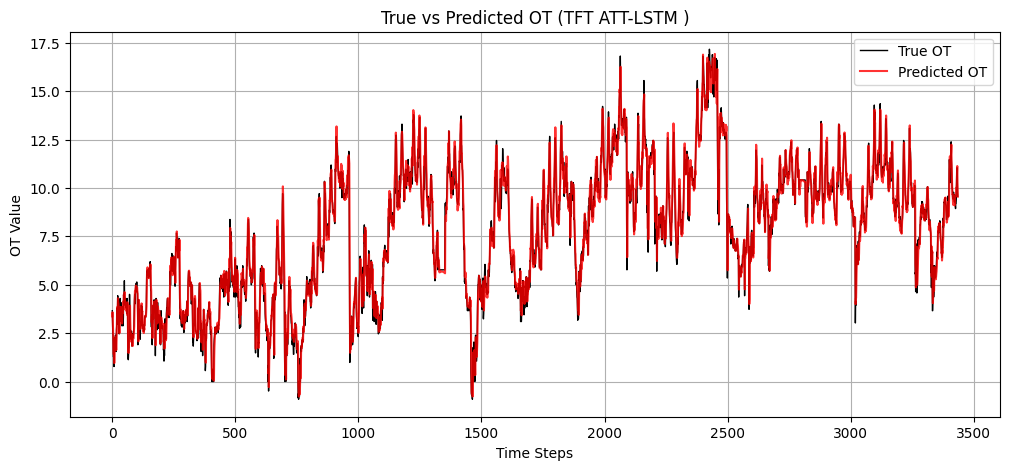

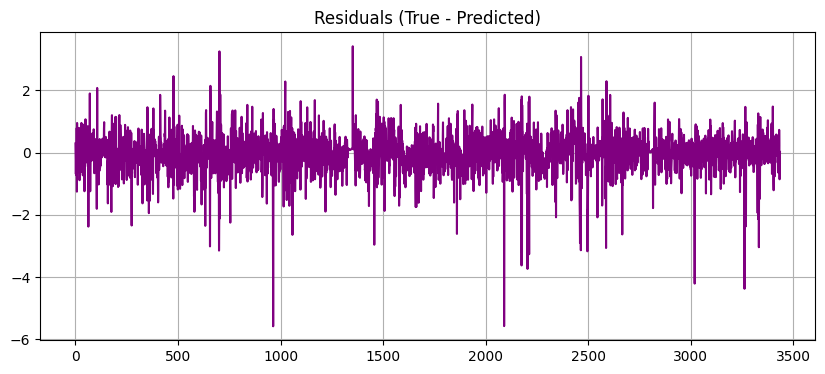

Total Area = 1485.8907268159091
Area + = 666.8667007498443
Area - = -819.0240260660648
RMS = 0.6299864568239584


In [13]:
model_build_TFTattlstm_model = build_TFTattlstm_model2(
    input_shape=(SEQ_LEN, X_train_scaled.shape[2]),
    lstm1_units=128,
    lstm2_units=128,
    dense_units=16,
    num_heads=8,
    model_dim=64,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm = model_build_TFTattlstm_model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_scaled = model_build_TFTattlstm_model.predict(X_test_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_true = y_pred_TFTattlstm_true.reshape(y_pred_TFTattlstm_scaled.shape[0],
                                                                y_pred_TFTattlstm_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_seq, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM )')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_seq - y_pred_TFTattlstm_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


res = y_test_seq.squeeze() - y_pred_TFTattlstm_true.squeeze()
area_total_TFTattlstm = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm)
area_positive_TFTattlstm = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm)
print("Area - =", area_negative_TFTattlstm)
vol_rms = np.sqrt(np.mean(res**2))
print("RMS =", vol_rms)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 48, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_17 (Lambda)  │ (None, 48, 6)     │          0 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_18 (Lambda)  │ (None, 48, 1)     │          0 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_28 (LSTM)      │ (None, 48, 64)    │     18,176 │ lambda_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_29 (LSTM)      │ (None, 48, 64)    │     16,896 │ lambda_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 48, 64)    │          0 │ lstm_28[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 48, 64)    │          0 │ lstm_29[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ dropout_32[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ dropout_33[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_19 (Lambda)  │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_20 (Lambda)  │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tft_temporal_atten… │ (None, None, 256) │    116,224 │ lambda_19[0][0],  │
│ (TFTTemporalAttent… │                   │            │ lambda_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, None, 1)   │        257 │ tft_temporal_att… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 160,001 (625.00 KB)

 Trainable params: 160,001 (625.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.1273 - mae: 0.1025 - val_loss: 0.0016 - val_mae: 0.0310
Epoch 2/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0044 - mae: 0.0512 - val_loss: 0.0017 - val_mae: 0.0330
Epoch 3/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0039 - mae: 0.0489 - val_loss: 9.0348e-04 - val_mae: 0.0226
Epoch 4/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0038 - mae: 0.0471 - val_loss: 0.0042 - val_mae: 0.0584
Epoch 5/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0027 - mae: 0.0407 - val_loss: 0.0014 - val_mae: 0.0328
Epoch 6/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0023 - mae: 0.0373 - val_loss: 0.0012 - val_mae: 0.0271
Epoch 7/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0019 - mae: 0.0344 - val_loss: 7.2465e-04 - val_mae: 0.0221
Epoch 8/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0020 - mae: 0.0353 - val_loss: 4.0228e-04 - val_mae: 0.0151
Epoch 9/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 7s

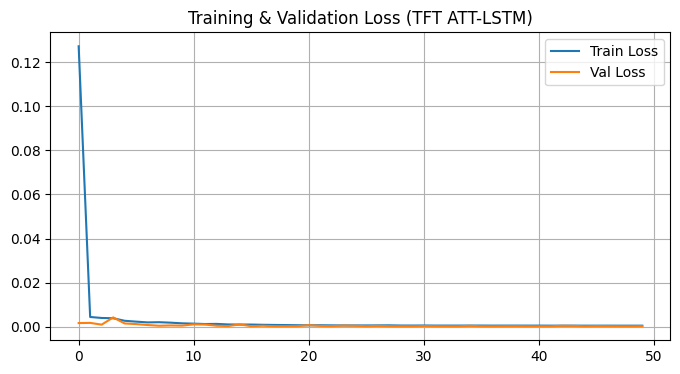

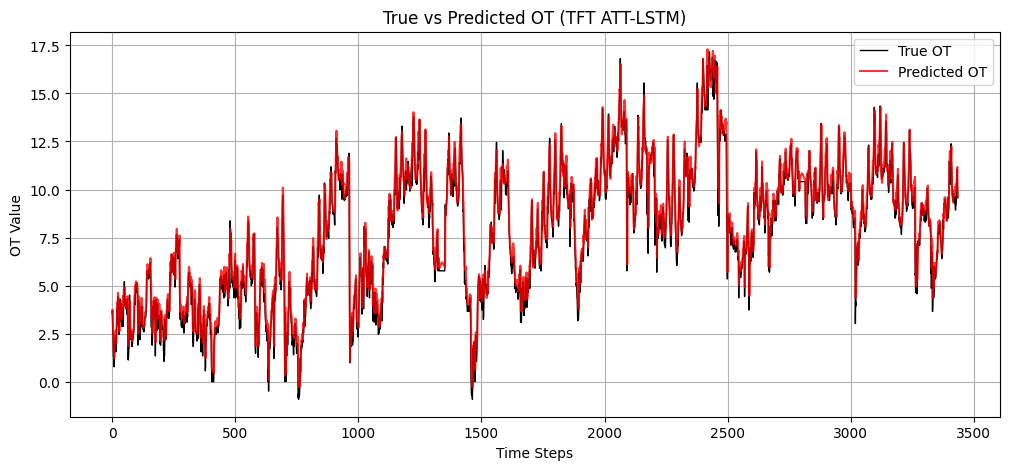

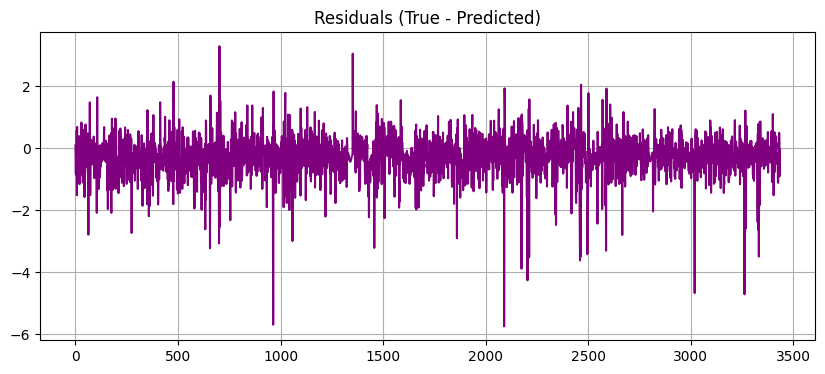

Total Area = 1686.2304850313812
Area + = 340.946076951921
Area - = -1345.2844080794603
RMS = 0.6939342254192297


In [21]:
model_build_TFTattlstm_model = build_TFTattlstm_model3(
    input_shape=(SEQ_LEN, X_train_scaled.shape[2]),
    lstm1_units=64,
    dense_units=4,
    num_heads=8,
    model_dim=256,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm = model_build_TFTattlstm_model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_scaled = model_build_TFTattlstm_model.predict(X_test_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_true = y_pred_TFTattlstm_true.reshape(y_pred_TFTattlstm_scaled.shape[0],
                                                                y_pred_TFTattlstm_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_seq, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_seq - y_pred_TFTattlstm_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


res = y_test_seq.squeeze() - y_pred_TFTattlstm_true.squeeze()
area_total_TFTattlstm = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm)
area_positive_TFTattlstm = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm)
print("Area - =", area_negative_TFTattlstm)
vol_rms = np.sqrt(np.mean(res**2))
print("RMS =", vol_rms)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 48, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 48, 1)     │          0 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 48, 6)     │          0 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 48, 32)    │      4,352 │ lambda_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 48, 32)    │      4,992 │ lambda_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 48, 32)    │          0 │ lstm_13[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 48, 32)    │          0 │ lstm_12[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 32)        │      1,088 │ dropout_14[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 32)        │      1,088 │ dropout_13[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, 1, 32)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 1, 32)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cross_attention     │ (None, 1, 32)     │     67,104 │ lambda_10[0][0],  │
│ (CrossAttention)    │                   │            │ lambda_9[0][0],   │
│                     │                   │            │ lambda_9[0][0],   │
│                     │                   │            │ lambda_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 32)     │          0 │ cross_attention[… │
│ (Concatenate)       │                   │            │ cross_attention[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2, 32)     │     67,104 │ concatenate[0][0… │
│ (MultiHeadAttentio… │                   │            │ concatenate[0][0… │
│                     │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 2, 32)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2, 32)     │         64 │ dropout_17[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 8)         │      1,184 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1)         │          9 │ bidirectional_2[

 Total params: 146,985 (574.16 KB)

 Trainable params: 146,985 (574.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0063 - mae: 0.0573 - val_loss: 0.0014 - val_mae: 0.0278
Epoch 2/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0025 - mae: 0.0384 - val_loss: 0.0010 - val_mae: 0.0269
Epoch 3/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0018 - mae: 0.0324 - val_loss: 4.7043e-04 - val_mae: 0.0160
Epoch 4/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0014 - mae: 0.0283 - val_loss: 4.3539e-04 - val_mae: 0.0164
Epoch 5/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0012 - mae: 0.0263 - val_loss: 4.2385e-04 - val_mae: 0.0162
Epoch 6/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0010 - mae: 0.0241 - val_loss: 4.0475e-04 - val_mae: 0.0152
Epoch 7/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 9.6951e-04 - mae: 0.0234 - val_loss: 3.3890e-04 - val_mae: 0.0137
Epoch 8/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 8.5939e-04 - mae: 0.0220 - val_loss: 2.5287e-04 - val_mae: 0.0119
Epoch 9/50
868/868

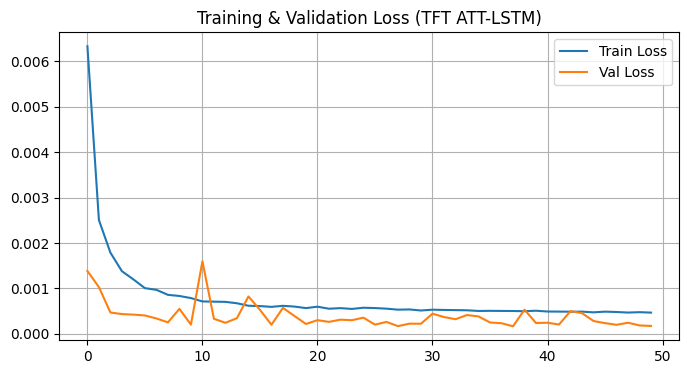

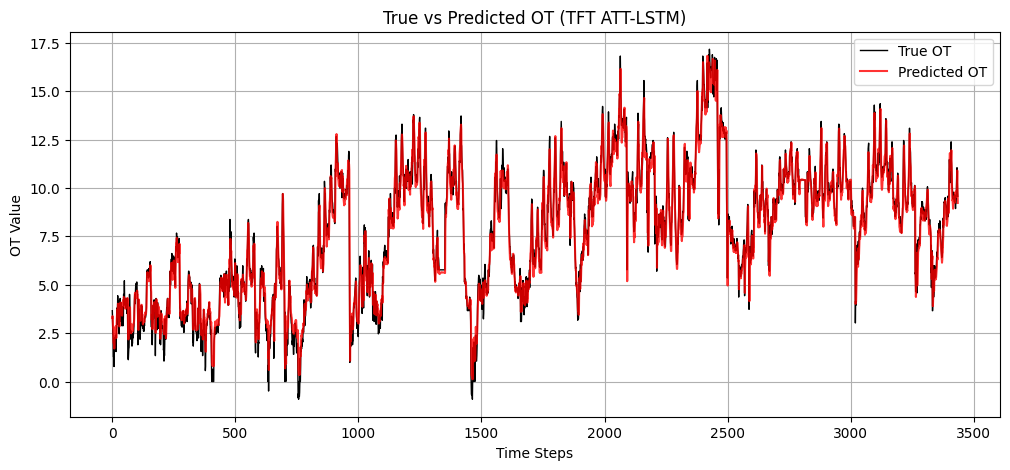

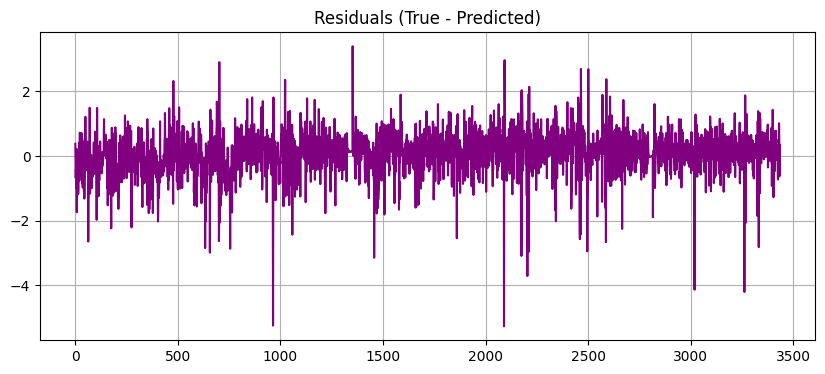

Total Area = 1634.5706272274256
Area + = 923.9632073640823
Area - = -710.6074198633432
RMS = 0.6617438784662782


In [15]:
model_build_TFTattlstm_model = build_TFTattlstm_model4(
    input_shape=(SEQ_LEN, X_train_scaled.shape[2]),
    lstm1_units=32,
    dense_units=4,
    num_heads=8,
    model_dim=64,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm = model_build_TFTattlstm_model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_scaled = model_build_TFTattlstm_model.predict(X_test_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_true = y_pred_TFTattlstm_true.reshape(y_pred_TFTattlstm_scaled.shape[0],
                                                                y_pred_TFTattlstm_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_seq, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_seq - y_pred_TFTattlstm_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


res = y_test_seq.squeeze() - y_pred_TFTattlstm_true.squeeze()
area_total_TFTattlstm = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm)
area_positive_TFTattlstm = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm)
print("Area - =", area_negative_TFTattlstm)
vol_rms = np.sqrt(np.mean(res**2))
print("RMS =", vol_rms)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 48, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_11 (Lambda)  │ (None, 48, 6)     │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_12 (Lambda)  │ (None, 48, 1)     │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 48, 64)    │     18,176 │ lambda_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 48, 64)    │     16,896 │ lambda_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 48, 64)    │          0 │ lstm_15[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 48, 64)    │          0 │ lstm_16[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ dropout_18[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ dropout_19[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_14 (Lambda)  │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2, 64)     │          0 │ lambda_13[0][0],  │
│ (Concatenate)       │                   │            │ lambda_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 128)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 16)        │      2,064 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 16)        │      2,064 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kl_divergence_layer │ [(None, 16),      │          0 │ dense_24[0][0],   │
│ (KLDivergenceLayer) │ (None, 16)]       │            │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 16)        │          0 │ kl_divergence_la… │
│                     │                   │            │ kl_divergence_la… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │      1,088 │ sampling[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 128)       │      8,320 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 2, 64)     │          0 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tft_temporal_atten… │ (None, None, 256) │    116,224 │ reshape_2[0][0],

 Total params: 190,257 (743.19 KB)

 Trainable params: 190,257 (743.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0338 - mae: 0.1437 - val_loss: 0.0190 - val_mae: 0.1215
Epoch 2/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0316 - mae: 0.1409 - val_loss: 0.0250 - val_mae: 0.1433
Epoch 3/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0316 - mae: 0.1408 - val_loss: 0.0231 - val_mae: 0.1368
Epoch 4/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0315 - mae: 0.1408 - val_loss: 0.0268 - val_mae: 0.1492
Epoch 5/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0316 - mae: 0.1409 - val_loss: 0.0246 - val_mae: 0.1419
Epoch 6/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0316 - mae: 0.1408 - val_loss: 0.0211 - val_mae: 0.1293
Epoch 7/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0315 - mae: 0.1409 - val_loss: 0.0207 - val_mae: 0.1281
Epoch 8/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0316 - mae: 0.1408 - val_loss: 0.0244 - val_mae: 0.1412
Epoch 9/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step 

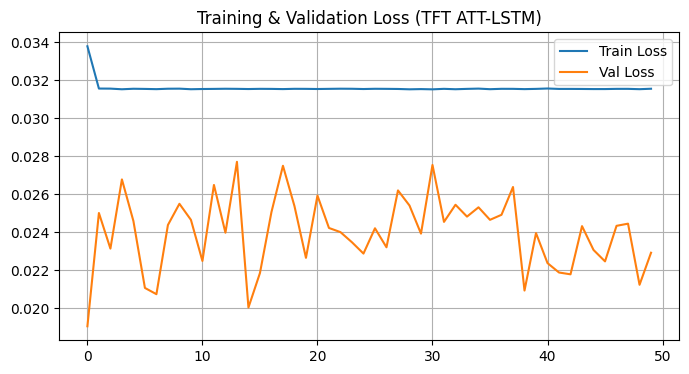

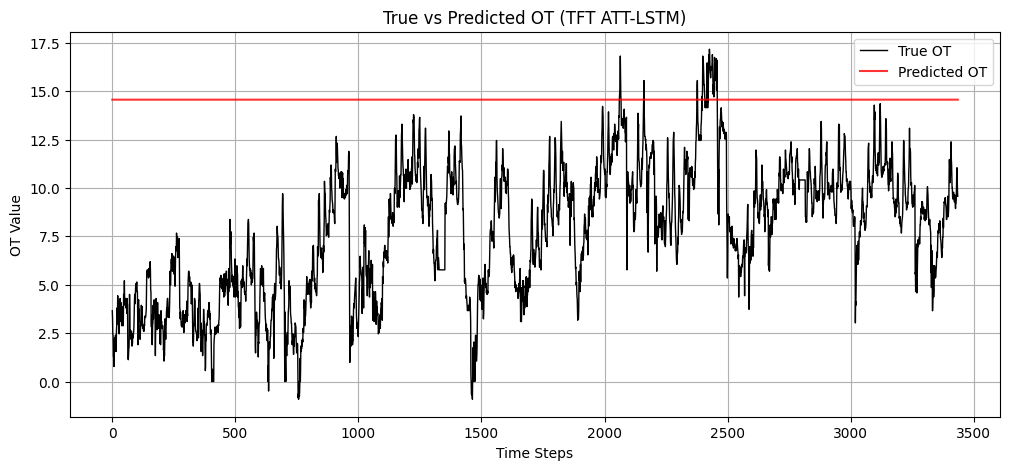

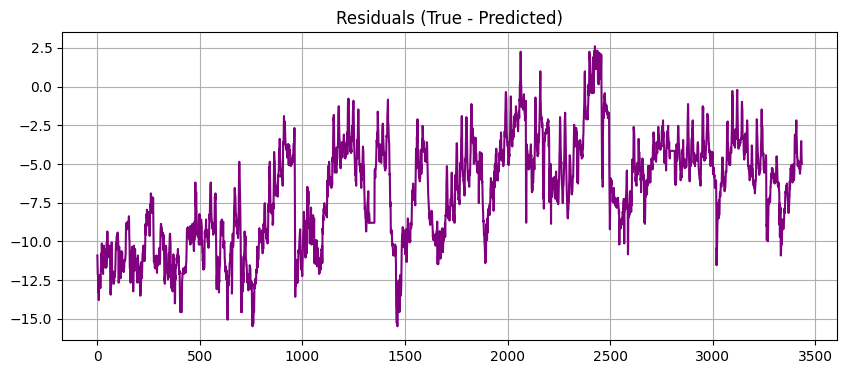

Total Area = 23407.581911295652
Area + = 78.38481330871582
Area - = -23329.197097986937
RMS = 7.582261727168298


In [16]:
model_build_TFTattlstm_model = build_TFTattlstm_model5(
    input_shape=(SEQ_LEN, X_train_scaled.shape[2]),
    lstm1_units=64,
    dense_units=8,
    num_heads=8,
    model_dim=256,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm = model_build_TFTattlstm_model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_scaled = model_build_TFTattlstm_model.predict(X_test_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_true = y_pred_TFTattlstm_true.reshape(y_pred_TFTattlstm_scaled.shape[0],
                                                                y_pred_TFTattlstm_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_seq, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_seq - y_pred_TFTattlstm_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


res = y_test_seq.squeeze() - y_pred_TFTattlstm_true.squeeze()
area_total_TFTattlstm = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm)
area_positive_TFTattlstm = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm)
print("Area - =", area_negative_TFTattlstm)
vol_rms = np.sqrt(np.mean(res**2))
print("RMS =", vol_rms)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 48, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_15 (Lambda)  │ (None, 48, 6)     │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_16 (Lambda)  │ (None, 48, 1)     │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 48, 64)    │     18,176 │ lambda_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ (None, 48, 64)    │     16,896 │ lambda_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 48, 64)    │          0 │ lstm_18[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 48, 64)    │          0 │ lstm_19[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ performer_attention │ (None, 48, 256)   │    115,776 │ dropout_21[0][0], │
│ (PerformerAttentio… │                   │            │ dropout_21[0][0], │
│                     │                   │            │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ performer_attentio… │ (None, 48, 256)   │    115,776 │ dropout_22[0][0], │
│ (PerformerAttentio… │                   │            │ dropout_22[0][0], │
│                     │                   │            │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group1_last_step    │ (None, 256)       │          0 │ performer_attent… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group2_last_step    │ (None, 256)       │          0 │ performer_attent… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 512)       │          0 │ group1_last_step… │
│ (Concatenate)       │                   │            │ group2_last_step… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 8)         │      4,104 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 1)         │          9 │ dense_41[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 270,737 (1.03 MB)

 Trainable params: 270,609 (1.03 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0062 - mae: 0.0507 - val_loss: 7.1570e-04 - val_mae: 0.0199
Epoch 2/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0018 - mae: 0.0324 - val_loss: 0.0012 - val_mae: 0.0303
Epoch 3/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0012 - mae: 0.0256 - val_loss: 3.7463e-04 - val_mae: 0.0148
Epoch 4/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 8.6913e-04 - mae: 0.0222 - val_loss: 3.7338e-04 - val_mae: 0.0151
Epoch 5/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 7.8058e-04 - mae: 0.0211 - val_loss: 7.8226e-04 - val_mae: 0.0242
Epoch 6/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 6.9708e-04 - mae: 0.0197 - val_loss: 2.4323e-04 - val_mae: 0.0114
Epoch 7/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 6.4615e-04 - mae: 0.0190 - val_loss: 2.8040e-04 - val_mae: 0.0124
Epoch 8/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 5.8083e-04 - mae: 0.0178 - val_loss: 3.7046e-04 - val_mae: 0.0157
Epoc

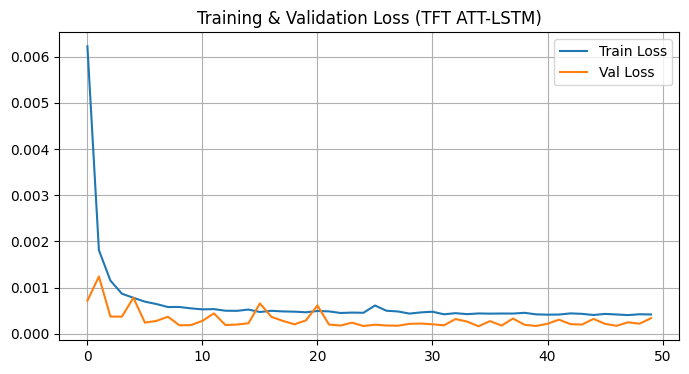

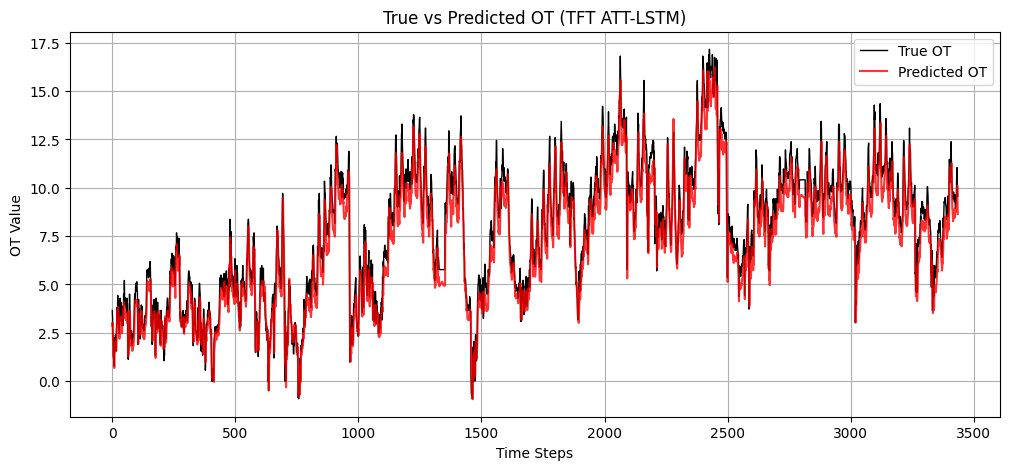

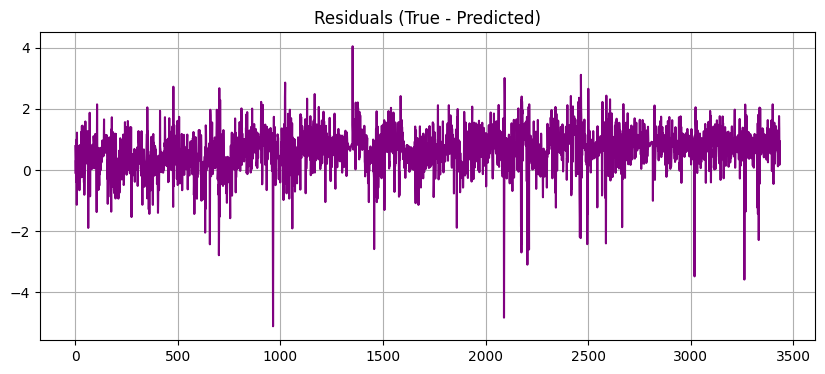

Total Area = 2665.911178074777
Area + = 2429.248900158331
Area - = -236.66227791644633
RMS = 0.9232405871941113


In [17]:
model_build_TFTattlstm_model = build_TFTattlstm_model6(
    input_shape=(SEQ_LEN, X_train_scaled.shape[2]),
    lstm1_units=64,
    dense_units=8,
    num_heads=32,
    model_dim=256,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm = model_build_TFTattlstm_model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_scaled = model_build_TFTattlstm_model.predict(X_test_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_true = y_pred_TFTattlstm_true.reshape(y_pred_TFTattlstm_scaled.shape[0],
                                                                y_pred_TFTattlstm_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_seq, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_seq - y_pred_TFTattlstm_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


res = y_test_seq.squeeze() - y_pred_TFTattlstm_true.squeeze()
area_total_TFTattlstm = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm)
area_positive_TFTattlstm = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm)
print("Area - =", area_negative_TFTattlstm)
vol_rms = np.sqrt(np.mean(res**2))
print("RMS =", vol_rms)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 48, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 48, 16)    │      1,024 │ input_layer_12[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 48, 16)    │          0 │ bidirectional_7[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 48, 16)    │      1,024 │ input_layer_12[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_31 (LSTM)      │ (None, 48, 130)   │     76,440 │ dropout_35[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 48, 16)    │          0 │ bidirectional_8[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 130)       │     17,160 │ lstm_31[0][0]     │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_33 (LSTM)      │ (None, 48, 130)   │     76,440 │ dropout_36[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group1_bahdanau_ex… │ (None, 1, 130)    │          0 │ attention_layer_… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ performer_attentio… │ (None, 48, 32)    │     13,888 │ lstm_33[0][0],    │
│ (PerformerAttentio… │                   │            │ lstm_33[0][0],    │
│                     │                   │            │ lstm_33[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group1_last_step    │ (None, 130)       │          0 │ group1_bahdanau_… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group2_last_step    │ (None, 32)        │          0 │ performer_attent… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 162)       │          0 │ group1_last_step… │
│ (Concatenate)       │                   │            │ group2_last_step… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_59 (Dense)    │ (None, 1)         │        163 │ concatenate_4[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 186,139 (727.11 KB)

 Trainable params: 185,883 (726.11 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0032 - mae: 0.0408 - val_loss: 0.0015 - val_mae: 0.0319
Epoch 2/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0013 - mae: 0.0275 - val_loss: 4.9065e-04 - val_mae: 0.0162
Epoch 3/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0010 - mae: 0.0243 - val_loss: 3.7796e-04 - val_mae: 0.0141
Epoch 4/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 9.2637e-04 - mae: 0.0229 - val_loss: 3.7144e-04 - val_mae: 0.0139
Epoch 5/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 8.6565e-04 - mae: 0.0221 - val_loss: 2.7205e-04 - val_mae: 0.0120
Epoch 6/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 7.6398e-04 - mae: 0.0207 - val_loss: 2.8831e-04 - val_mae: 0.0123
Epoch 7/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 7.2782e-04 - mae: 0.0203 - val_loss: 2.4076e-04 - val_mae: 0.0117
Epoch 8/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 6.3967e-04 - mae: 0.0188 - val_loss: 2.7512e-04 - val_mae:

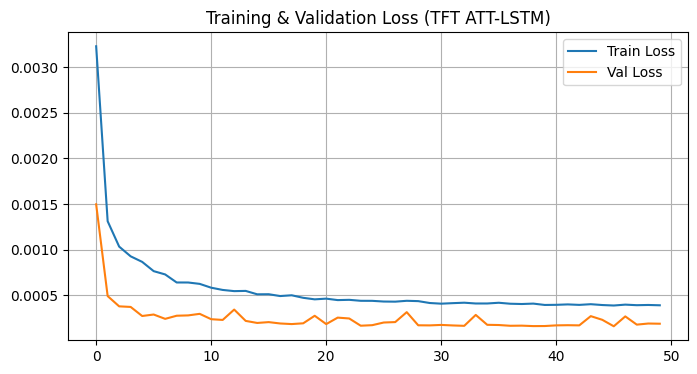

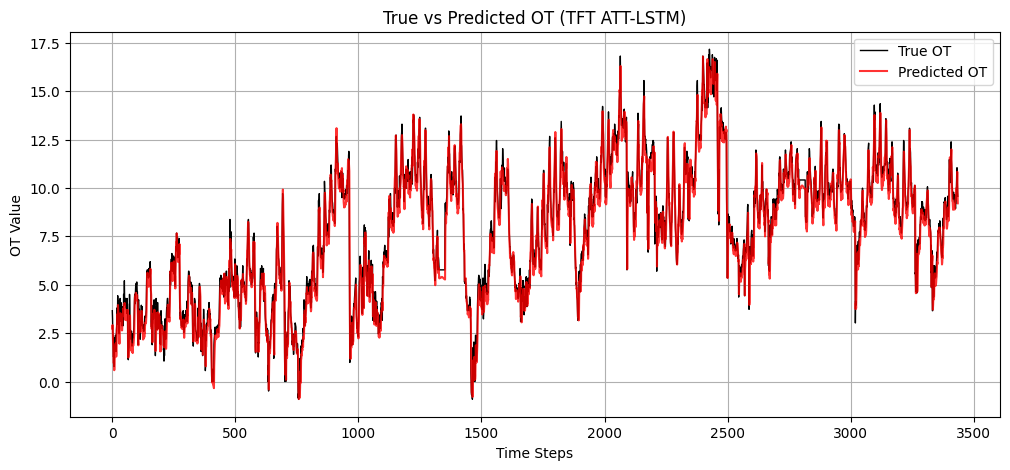

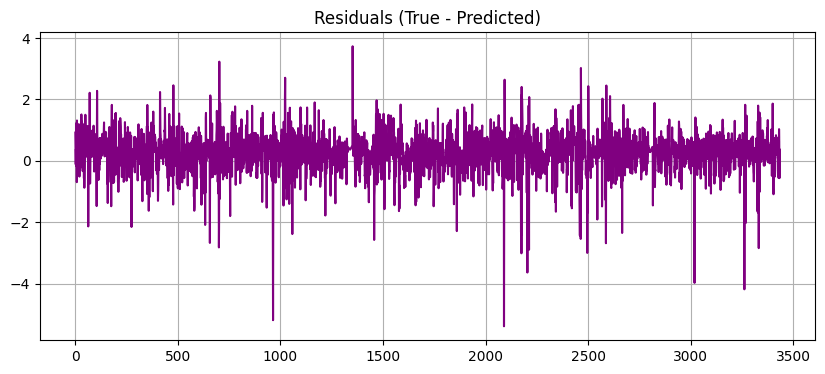

Total Area = 1760.6352289244533
Area + = 1299.5453293770552
Area - = -461.0898995473981
RMS = 0.6857931783818085


In [22]:
model_build_TFTattlstm_model = build_TFTattlstm_model7(
    input_shape=(SEQ_LEN, X_train_scaled.shape[2]),
    lstm1_units=130,
    dense_units=8,
    num_heads=2,
    model_dim=32,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm = model_build_TFTattlstm_model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_scaled = model_build_TFTattlstm_model.predict(X_test_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_true = y_pred_TFTattlstm_true.reshape(y_pred_TFTattlstm_scaled.shape[0],
                                                                y_pred_TFTattlstm_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_seq, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_seq - y_pred_TFTattlstm_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

res = y_test_seq.squeeze() - y_pred_TFTattlstm_true.squeeze()
area_total_TFTattlstm = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm)
area_positive_TFTattlstm = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm)
print("Area - =", area_negative_TFTattlstm)
vol_rms = np.sqrt(np.mean(res**2))
print("RMS =", vol_rms)

# BidirectionalLSTM

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 48, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 48, 200)        │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 48, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,901 (808.21 KB)

 Trainable params: 206,901 (808.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0026 - mae: 0.0352 - val_loss: 2.9449e-04 - val_mae: 0.0129
Epoch 2/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0013 - mae: 0.0271 - val_loss: 9.5355e-04 - val_mae: 0.0260
Epoch 3/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0010 - mae: 0.0243 - val_loss: 2.3861e-04 - val_mae: 0.0110
Epoch 4/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 8.3785e-04 - mae: 0.0215 - val_loss: 1.9456e-04 - val_mae: 0.0098
Epoch 5/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 8.0165e-04 - mae: 0.0209 - val_loss: 1.9313e-04 - val_mae: 0.0101
Epoch 6/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 7.5936e-04 - mae: 0.0202 - val_loss: 2.3666e-04 - val_mae: 0.0112
Epoch 7/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 6.8665e-04 - mae: 0.0192 - val_loss: 4.1478e-04 - val_mae: 0.0165
Epoch 8/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 6.8033e-04 - mae: 0.0191 - val_loss: 2.8575e-04 - val_mae: 0.0127
E

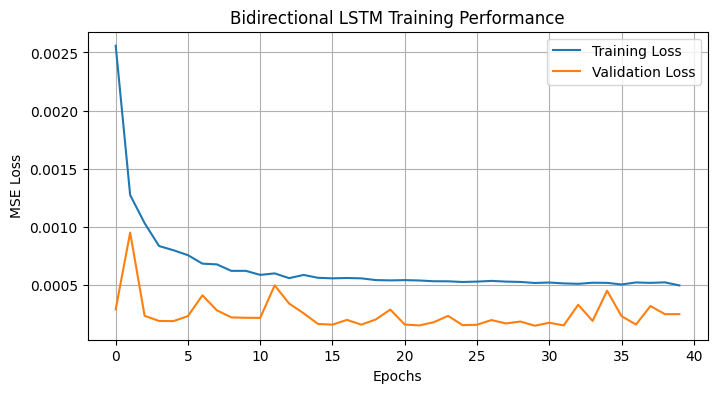

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


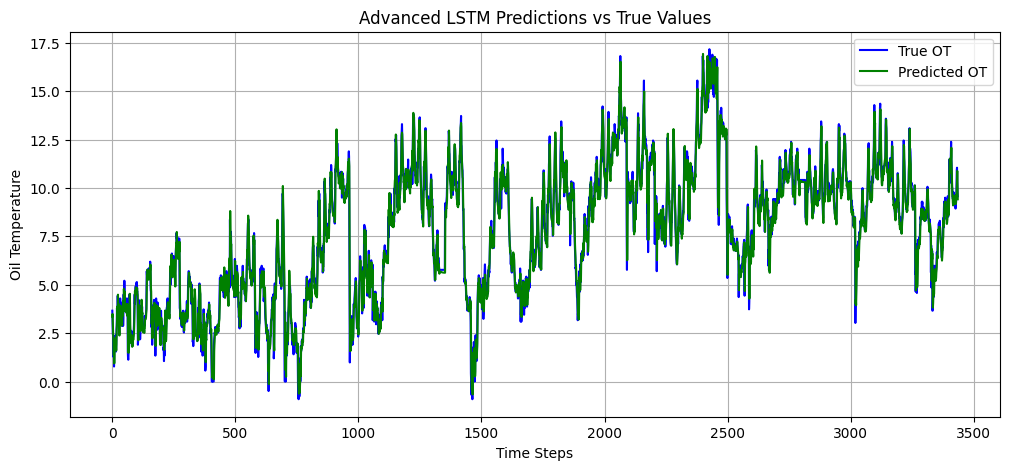

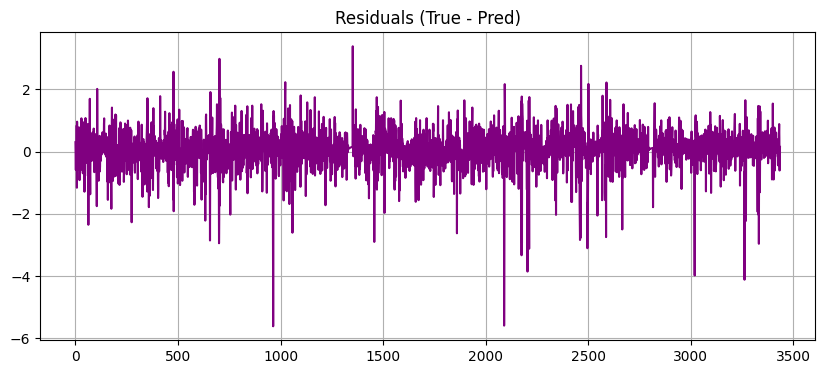

Total Area = 1474.049291536212
Area + = 838.7016443759203
Area - = -635.3476471602917
RMS = 0.6209011963077675


In [19]:
# ---------------------------
# 5. Build Bidirectional_LSTM model
# ---------------------------
def build_Bidirectional_lstm_model(input_shape, units=LSTM_UNITS, dropout=DROPOUT):
    inp = Input(shape=input_shape)
    x = Bidirectional(LSTM(units, return_sequences=True))(inp)
    x = Dropout(dropout)(x)
    x = LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LEARNING_RATE), loss='mse', metrics=['mae'])
    return model

Bidirectional_lstm = build_Bidirectional_lstm_model((SEQ_LEN, len(FEATURE_COLS)),100)
Bidirectional_lstm.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history_Bidirectional_lstm = Bidirectional_lstm.fit(
    X_train_scaled, y_train_scaled,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(8, 4))
plt.plot(history_Bidirectional_lstm.history['loss'], label='Training Loss')
plt.plot(history_Bidirectional_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Bidirectional LSTM Training Performance')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
y_pred_scaled_Bidirectional_lstm = Bidirectional_lstm.predict(X_test_scaled)
y_pred_Bidirectional_lstm_true = scaler_y.inverse_transform(y_pred_scaled_Bidirectional_lstm.reshape(-1, 1)).flatten()

# Plot predictions vs true values
plt.figure(figsize=(12, 5))
plt.plot(y_test_seq, label='True OT', color='blue')
plt.plot(y_pred_Bidirectional_lstm_true, label='Predicted OT', color='green')
plt.xlabel('Time Steps')
plt.ylabel('Oil Temperature')
plt.title('Advanced LSTM Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
res = y_test_seq.squeeze() - y_pred_Bidirectional_lstm_true
plt.plot(res, color='purple')
plt.title('Residuals (True - Pred)')
plt.grid(True)
plt.show()

res = y_test_seq.squeeze() - y_pred_Bidirectional_lstm_true
area_total_Bidirectional_lstm = np.trapezoid(np.abs(res))
print("Total Area =", area_total_Bidirectional_lstm)
area_positive_Bidirectional_lstm = np.trapezoid(np.clip(res, 0, None))
area_negative_Bidirectional_lstm = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_Bidirectional_lstm)
print("Area - =", area_negative_Bidirectional_lstm)
vol_rms = np.sqrt(np.mean(res**2))
print("RMS =", vol_rms)

# LSTM

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 48, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 48, 128)        │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,345 (786.50 KB)

 Trainable params: 201,345 (786.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0028 - mae: 0.0377 - val_loss: 6.0445e-04 - val_mae: 0.0204
Epoch 2/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0014 - mae: 0.0284 - val_loss: 3.1072e-04 - val_mae: 0.0125
Epoch 3/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0011 - mae: 0.0250 - val_loss: 3.7578e-04 - val_mae: 0.0157
Epoch 4/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 9.4248e-04 - mae: 0.0230 - val_loss: 3.4714e-04 - val_mae: 0.0153
Epoch 5/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 8.5279e-04 - mae: 0.0217 - val_loss: 2.6345e-04 - val_mae: 0.0127
Epoch 6/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 7.4545e-04 - mae: 0.0202 - val_loss: 2.2377e-04 - val_mae: 0.0108
Epoch 7/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 7.1597e-04 - mae: 0.0197 - val_loss: 3.4923e-04 - val_mae: 0.0148
Epoch 8/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 6.5409e-04 - mae: 0.0188 - val_loss: 3.4470e-04 - val_mae: 0.0148
Epoc

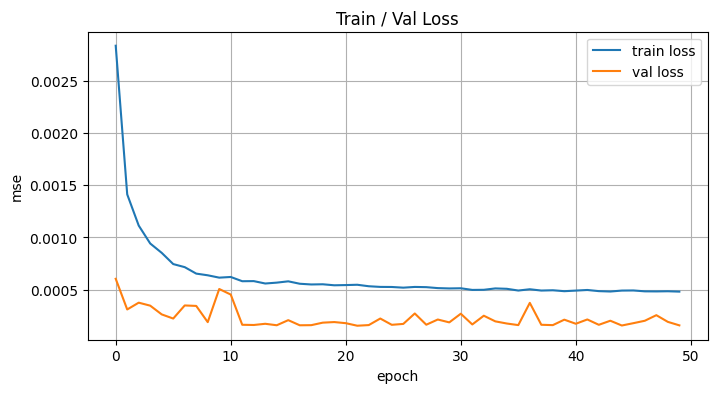

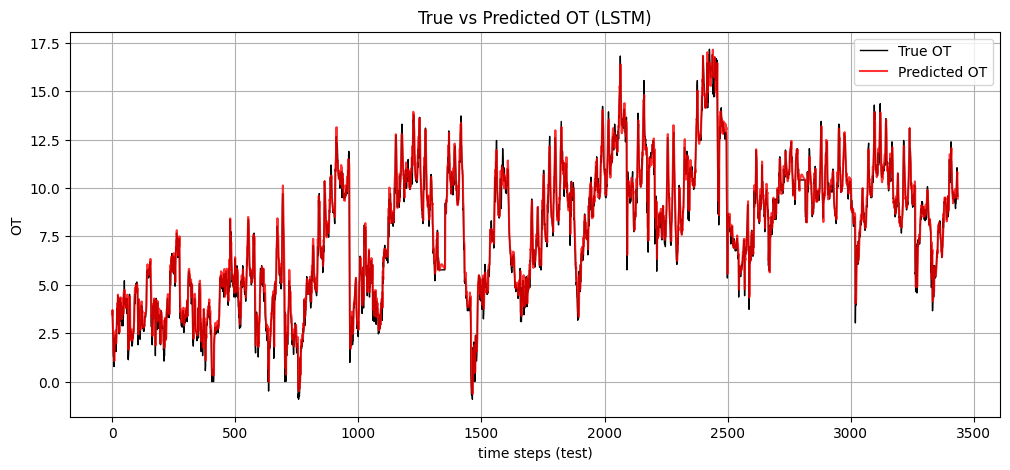

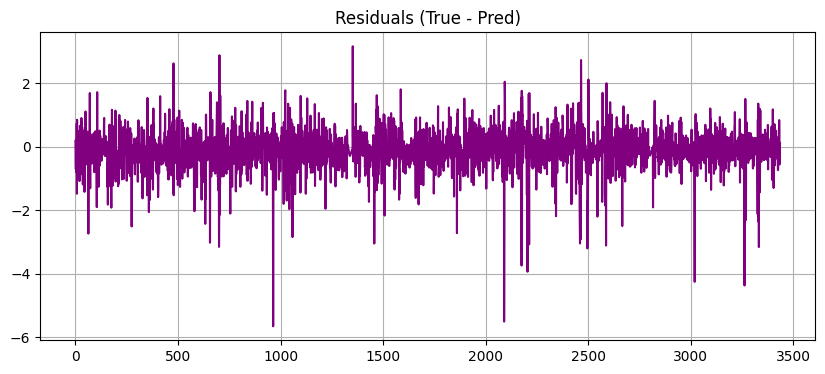

Total Area = 1480.387066937983
Area + = 538.5985000617802
Area - = -941.7885668762028
RMS = 0.6307159888671863


In [20]:
# ---------------------------
# 5. Build LSTM model
# ---------------------------
def build_lstm_model(input_shape, units=LSTM_UNITS, dropout=DROPOUT):
    inp = Input(shape=input_shape)
    x = LSTM(units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)
    x = LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LEARNING_RATE), loss='mse', metrics=['mae'])
    return model

model_lstm_model= build_lstm_model((SEQ_LEN, len(FEATURE_COLS)),128)
model_lstm_model.summary()

# ---------------------------
# 6. Train
# ---------------------------
history_lstm = model_lstm_model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# ---------------------------
# 7. Predict & inverse-transform
# ---------------------------
y_pred_lstm_scaled = model_lstm_model.predict(X_test_scaled)
y_pred_lstm_true = scaler_y.inverse_transform(y_pred_lstm_scaled).flatten()

# ---------------------------
# 9. Plots
# ---------------------------
plt.figure(figsize=(8,4))
plt.plot(history_lstm.history['loss'], label='train loss')
plt.plot(history_lstm.history['val_loss'], label='val loss')
plt.xlabel('epoch'); plt.ylabel('mse'); plt.legend(); plt.grid(True)
plt.title('Train / Val Loss')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_seq, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_lstm_true, label='Predicted OT', color='red', alpha=0.8)
plt.xlabel('time steps (test)')
plt.ylabel('OT')
plt.title('True vs Predicted OT (LSTM)')
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
res = y_test_seq.squeeze() - y_pred_lstm_true 
plt.plot(res, color='purple')
plt.title('Residuals (True - Pred)')
plt.grid(True)
plt.show()

res = y_test_seq.squeeze() - y_pred_lstm_true
area_total_lstm = np.trapezoid(np.abs(res))
print("Total Area =", area_total_lstm)
area_positive_lstm = np.trapezoid(np.clip(res, 0, None))
area_negative_lstm = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_lstm)
print("Area - =", area_negative_lstm)
vol_rms = np.sqrt(np.mean(res**2))
print("RMS =", vol_rms)

# Compare Models

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def compute_metrics(y_true, y_pred):
    min_len = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[:min_len], y_pred[:min_len]
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# Compute metrics
mse_Attlstm, rmse_Attlstm, mae_Attlstm, r2_attlstm = compute_metrics(y_pred_attlstm_true, y_test_seq)
mse_TAttlstm, rmse_TAttlstm, mae_TAttlstm, r2_Tattlstm = compute_metrics(y_pred_Tattlstm_true, y_test_seq)
mse_TFTAttlstm, rmse_TFTAttlstm, mae_TFTAttlstm, r2_TFTattlstm_vmd = compute_metrics(y_pred_TFTattlstm_true, y_test_seq)
mse_Lstm_Bidirectional, rmse_Lstm_Bidirectional, mae_Lstm_Bidirectional, r2_Lstm_Bidirectional = compute_metrics(y_pred_Bidirectional_lstm_true, y_test_seq)
mse_Attlstm, rmse_Attlstm, mae_Attlstm, r2_attlstm = compute_metrics(y_pred_attlstm_true, y_test_seq)
mse_Lstm, rmse_Lstm, mae_Lstm, r2_Lstm = compute_metrics(y_pred_lstm_true, y_test_seq)

# Print comparison
print("📈 Model Performance Comparison")
print(f"ATT-LSTM: MSE={mse_Attlstm:.4f}, RMSE={rmse_Attlstm:.4f}, MAE={mae_Attlstm:.4f}, R²={r2_attlstm:.4f}, total_area={area_total_attlstm:.4f}")
print(f"TATT-LSTM: MSE={mse_TAttlstm:.4f}, RMSE={rmse_TAttlstm:.4f}, MAE={mae_TAttlstm:.4f}, R²={r2_Tattlstm:.4f}, total_area={area_total_Tattlstm:.4f}")
print(f"TFTATT-LSTM: MSE={mse_TFTAttlstm:.4f}, RMSE={rmse_TFTAttlstm:.4f}, MAE={mae_TFTAttlstm:.4f}, R²={r2_TFTattlstm_vmd:.4f}, total_area={area_total_TFTattlstm:.4f}")
print(f"Bidirectional_Lstm: MSE={mse_Lstm_Bidirectional:.4f}, RMSE={rmse_Lstm_Bidirectional:.4f}, MAE={mae_Lstm_Bidirectional:.4f}, R²={r2_Lstm_Bidirectional:.4f}, total_area={area_total_Bidirectional_lstm:.4f}")
print(f"Lstm: MSE={mse_Lstm:.4f}, RMSE={rmse_Lstm:.4f}, MAE={mae_Lstm:.4f}, R²={r2_Lstm:.4f}, total_area={area_total_lstm:.4f}")


📈 Model Performance Comparison
ATT-LSTM: MSE=0.6886, RMSE=0.8298, MAE=0.6324, R²=0.9379, total_area=2187.4684
TATT-LSTM: MSE=0.7782, RMSE=0.8822, MAE=0.6971, R²=0.9342, total_area=2411.1327
TFTATT-LSTM: MSE=60.4737, RMSE=7.7765, MAE=7.0125, R²=0.0000, total_area=24255.1191
Bidirectional_Lstm: MSE=0.3879, RMSE=0.6228, MAE=0.4261, R²=0.9670, total_area=1473.9464
Lstm: MSE=0.5085, RMSE=0.7131, MAE=0.5484, R²=0.9547, total_area=1896.9124
